# Fig 3 + Ext Data Fig 3

This notebook produces all analyses in Figure 3 and Extended Data Figure 3.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats
from PIL import Image
from helper_funcs import *

# Import data

## TO DO: Set the following local paths the Source Data excel files for Figure 3 and Extended Data Figure 3

In [2]:
SOURCE_DATA_FIG = "/Users/iboyle/Files/TargetDiscovery/PELO/PELO-dev/Source Data/Figure 3.xlsx"
SOURCE_DATA_EXT_FIG = "/Users/iboyle/Files/TargetDiscovery/PELO/PELO-dev/Source Data/Ext Figure 3.xlsx"

In [3]:
redownload = False
gene_effect = read_in_data("CRISPRGeneEffect", redownload=redownload, index_col=0)
cn = read_in_data("OmicsCNGene", redownload=redownload, index_col=0)
mod_prof = read_in_data("OmicsDefaultModelProfiles", redownload=redownload)
hs_mut = read_in_data("OmicsSomaticMutationsMatrixHotspot", redownload=redownload, index_col=0)
sigs = read_in_data("OmicsSignatures", redownload=redownload, index_col=0)
model_meta = read_in_data("Model", redownload=redownload, index_col=0)

microsatellite_repeats = read_in_data("microsatellite_repeats", redownload=redownload, index_col=[0,1,2,3,4])

tcga_alterations = read_in_data("TCGA_alterations", redownload=redownload)

transcript_expr = read_in_data(
    "TTC37_transcript_expr", redownload=redownload, index_col=0
).rename(mod_prof.set_index("ProfileID")["ModelID"])

ccle_proteomics = read_in_data("ccle_proteomics")
ccle_proteomics = munge_ccle_proteomics(ccle_proteomics, model_meta)

df_9p21_cn = read_in_data("9p21_3_relative_copy_number", index_col=0, redownload=redownload)

Fetching local copy of CRISPRGeneEffect
Fetching local copy of OmicsCNGene
Fetching local copy of OmicsDefaultModelProfiles
Fetching local copy of OmicsSomaticMutationsMatrixHotspot
Fetching local copy of OmicsSignatures
Fetching local copy of Model
Fetching local copy of microsatellite_repeats
Fetching local copy of TCGA_alterations
Fetching local copy of TTC37_transcript_expr
Fetching local copy of 9p21_3_relative_copy_number


## NOTE: these data are from "Analysis for 9p21_3 Modifier Screen.ipynb"

In [4]:
seq_map = read_in_data("sequence_map_9p21_3", redownload=redownload)
guide_map = read_in_data("guide_map_9p21_3", redownload=redownload)
lfc = read_in_data("logfold_change_9p21_3", index_col=0, redownload=redownload)
crispr_mod_ge = read_in_data("gene_effect_9p21_3", index_col=0, redownload=redownload)

Fetching local copy of sequence_map_9p21_3
Fetching local copy of guide_map_9p21_3
Fetching local copy of logfold_change_9p21_3
Fetching local copy of gene_effect_9p21_3


# Prep Figure 3 panels

## Panel A: CRISPR modifier screen

In [5]:
#experimental design
crispr_mod = np.asarray(Image.open('crispr-mod.png'))

#gene effect comparison
fig3a_crispr_mod = (crispr_mod_ge.loc[["PELO1", "PELO2"]] - crispr_mod_ge.loc["Ch2-2"]).T.add_suffix(" - Ch2-2")
fig3a_crispr_mod["Type"] = guide_map.drop_duplicates(subset=["Target", "Function"]).set_index("Target")["Function"].replace({
    "Negative Control":"neg ctrl", "Lethal Control":"pos ctrl"
})

In [6]:
#get late timepoints
late_timepoint = seq_map.loc[seq_map["days"] == 21].copy()

#for each replicate, subtract the control Ch2-2 LFC from the PELO LFC
diffs = []
for rep in late_timepoint["replicate"].unique():
    #get only late timepoints
    reps = late_timepoint.loc[late_timepoint["replicate"] == rep]
    #find the control replicate
    control_rep = reps.loc[(reps["cell_line_name"] == "Ch2-2"), "sequence_ID"]
    #find each PELO replicate and subtract Ch2-2
    for pelo_rep in reps.loc[(reps["cell_line_name"].str.startswith("PELO")), "sequence_ID"]:
        diffs.append((lfc.loc[pelo_rep] - lfc.loc[control_rep]))
diffs = pd.concat(diffs, axis=0).stack().reset_index(level=0)
print("n", len(diffs))

#get the differences for the FOCAD guides and the non-FOCAD guides 
diff_list = diffs.groupby(
    (guide_map.set_index('sgRNA1')['Target'] == "FOCAD").loc[lambda x: ~x.index.duplicated(keep=False)]
)[0].apply(list)

mean_diffs = diff_list.apply(lambda x: np.mean(x))
print("effect size", mean_diffs.loc[True] - mean_diffs.loc[False])

#run a wilcoxon rank sum test to show that difference between PELO+FOCAD and Ch2-2+FOCAD is more negative then others
fig3a_stats = scipy.stats.ranksums(diff_list[True], diff_list[False], alternative='less')
fig3a_sig = to_scientific(fig3a_stats.pvalue)
fig3a_stats

n 552
effect size -0.7858243856971635


RanksumsResult(statistic=-8.948701955913272, pvalue=1.7984344441908752e-19)

## Panel B: FOCAD sufficiency

In [7]:
fig3b_data = pd.read_excel(SOURCE_DATA_FIG, sheet_name="Fig3b")

fig3b_viab = pd.DataFrame(
    fig3b_data.iloc[2:8, 1:3].values, index=fig3b_data.iloc[2:8, 0].rename("DOX"),
    columns=fig3b_data.iloc[1, 1:3].rename("gRNA")
).stack().to_frame("Relative Viability").reset_index()

In [8]:
#test whether FOCAD KO alongside DOX-mediated PELO KD leads to lower viability then neg control Ch2 KO
fig3b_stats = ttest_vs_negcons(
    fig3b_viab.loc[fig3b_viab["DOX"]=="DOX+"], "gRNA", neg_cons=["Ch2"], to_test=["FOCAD#2"],
    alternative="less", vals="Relative Viability"
).to_frame("DOX+").T
fig3b_sig = to_scientific(fig3b_stats.loc["DOX+", "p-val"], prefix="$p$=")
fig3b_stats

statistic         p-val  Effect Size    n
DOX+ -62.266406  1.992323e-07    -0.636372  6.0

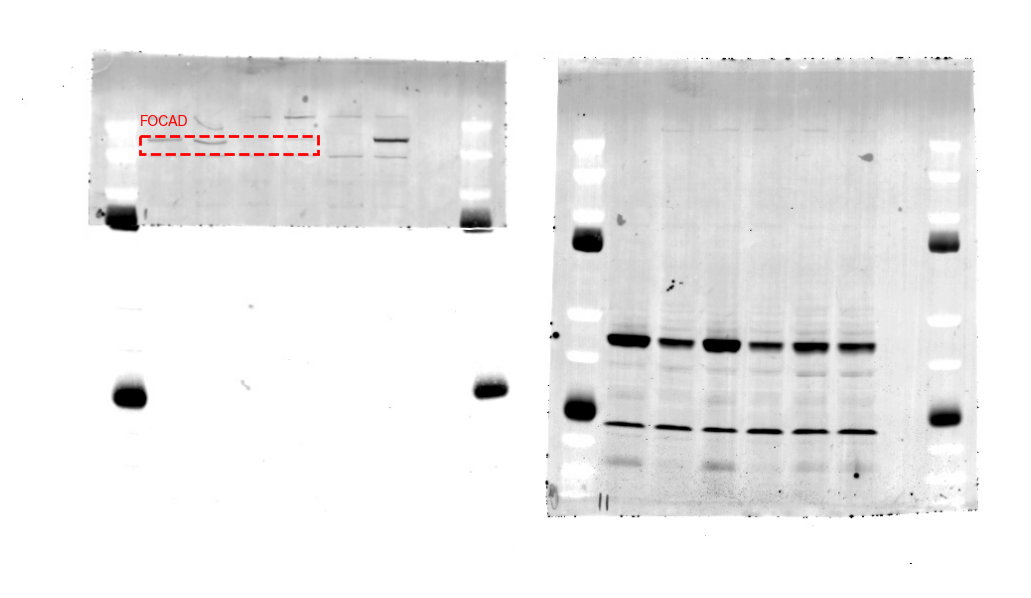

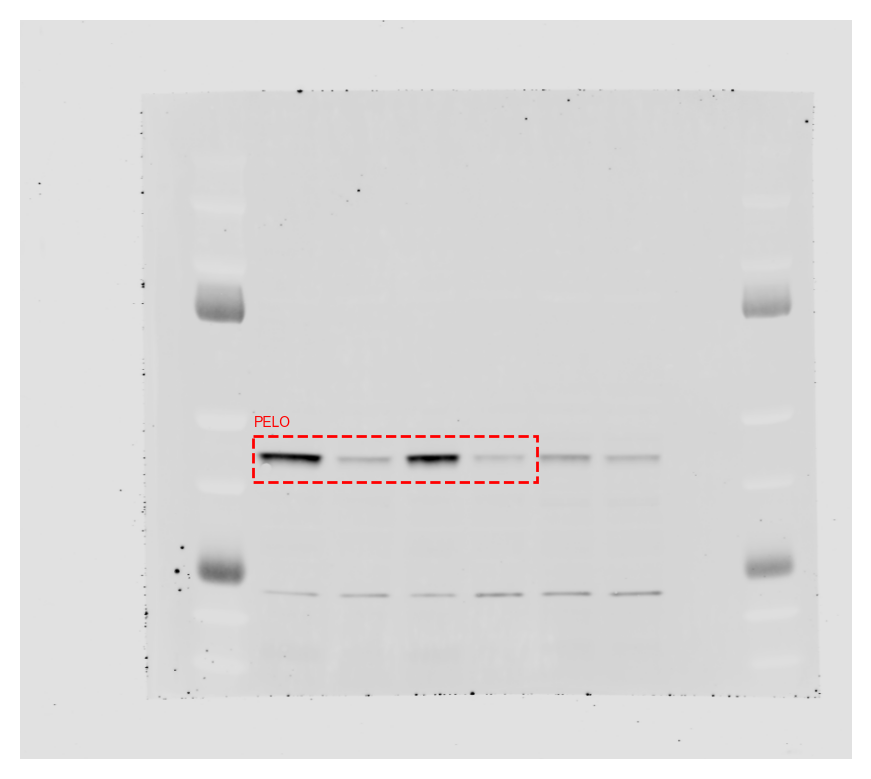

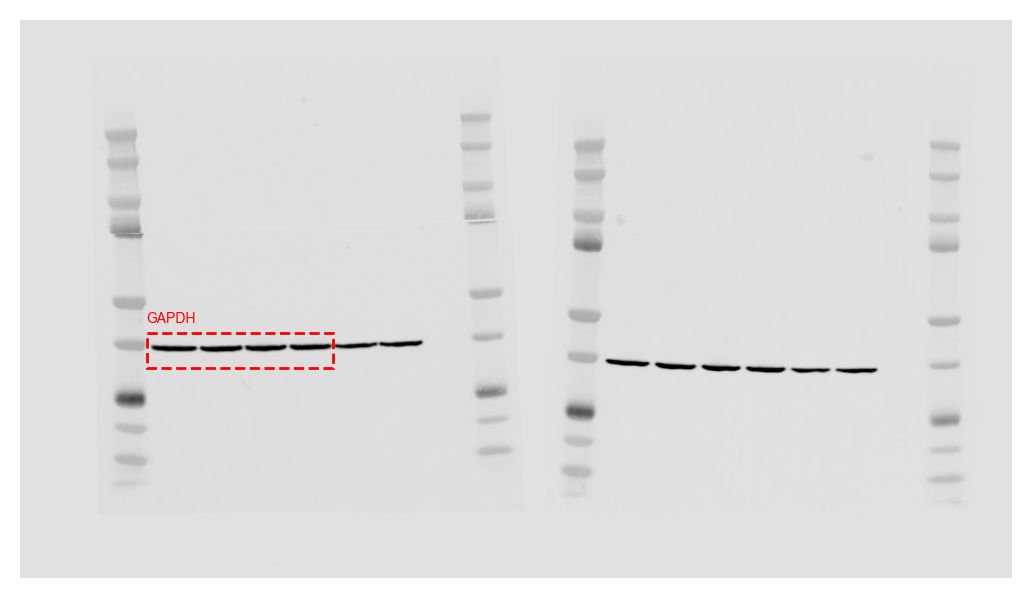

In [9]:
fig3b_FOCAD_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 3/Fig3b_FOCAD.tif', {"FOCAD":[116,135, 120,300]})
fig3b_PELO_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 3/Fig3b_PELO.tif', {"PELO":[500,555, 280,620]})
fig3b_GAPDH_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 3/Fig3b_GAPDH.tif', {"GAPDH":[315,350, 127,315]})

## Panel C: FOCAD necessity

In [10]:
fig3c_data = pd.read_excel(SOURCE_DATA_FIG, sheet_name="Fig3c")

fig3c_viab = pd.DataFrame(
    fig3c_data.iloc[2:8, 1:4].values, index=fig3c_data.iloc[2:8, 0].rename("DOX"),
    columns=fig3c_data.iloc[1, 1:4].rename("cDNA")
).stack().to_frame("Relative Viability").reset_index()

In [11]:
#test whether FOCAD cDNA overexpression in DOX-mediated PELO KD leads to increased viability over neg ctrl Luc cDNA
fig3c_stats = ttest_vs_negcons(
    fig3c_viab.loc[fig3c_viab["DOX"] == "DOX+"], "cDNA", neg_cons=["Luc"], to_test=["FOCAD"],
    alternative="greater", vals="Relative Viability"
).to_frame("DOX+").T
fig3c_sig = to_scientific(fig3c_stats.loc["DOX+", "p-val"], prefix="$p$=")
fig3c_stats

statistic    p-val  Effect Size    n
DOX+   4.117732  0.00732     0.470743  6.0

In [12]:
#test whether PELO cDNA overexpression in DOX-mediated PELO KD leads to increased viability over neg ctrl Luc cDNA
ttest_vs_negcons(
    fig3c_viab.loc[fig3c_viab["DOX"] == "DOX+"], "cDNA", neg_cons=["Luc"], to_test=["PELO"],
    alternative="greater", vals="Relative Viability"
).to_frame("PELO").T

statistic     p-val  Effect Size    n
PELO   4.691269  0.004684     0.479155  6.0

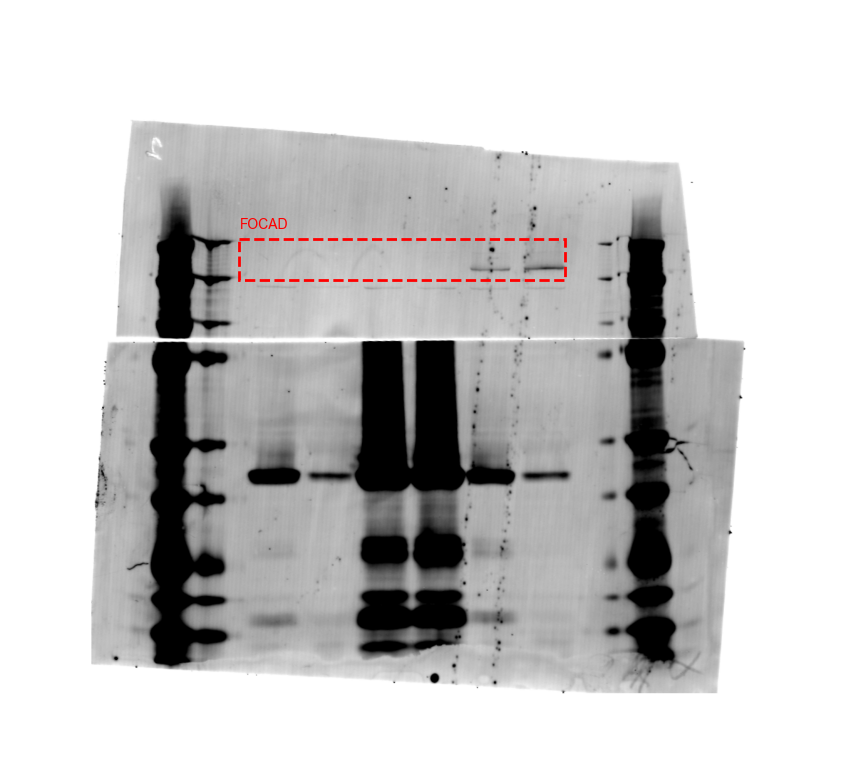

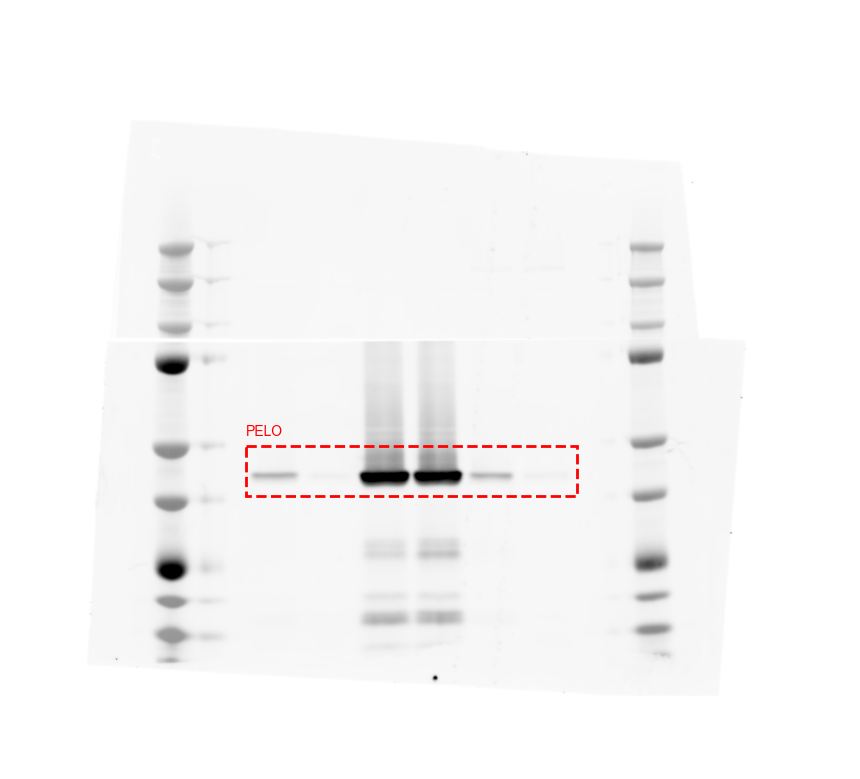

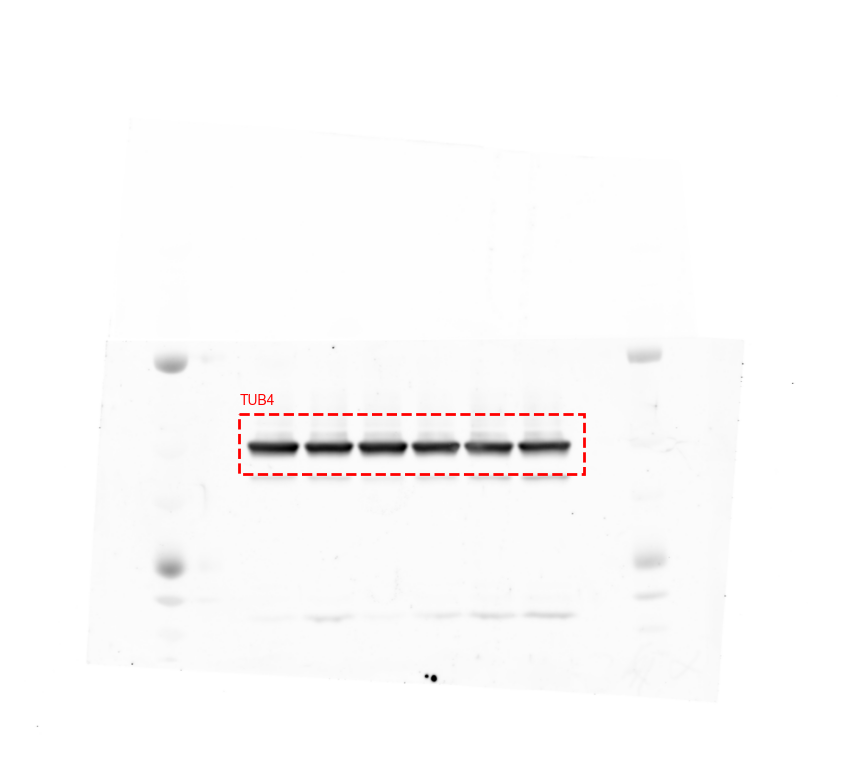

In [13]:
fig3c_FOCAD_cropped = crop_and_box_wb(IMG_FOLDER+"Figure 3/Fig3c_FOCAD.tif", {"FOCAD":[350,415, 350,870]})
fig3c_PELO_cropped = crop_and_box_wb(IMG_FOLDER+"Figure 3/Fig3c_PELO.tif", {"PELO":[680,760, 360,890]})
fig3c_a_tubulin_cropped = crop_and_box_wb(IMG_FOLDER+"Figure 3/Fig3c_a_tubulin.tif", {"TUB4":[630,725, 350,900]})

## Panel D/E: Microsatellite Repeats and TTC37 

In [14]:
msi_h = sigs.index[sigs["MSIScore"] > 20]
ttc37_loc = ("chr5", 95507014, "CCCTT", "11[A]", "GGTAT")

#pearson correlation for PELO depedence vs MS repeats in MSI-H cell lines
fig3d_volc = compare_it_continuous(
    gene_effect.loc[gene_effect.index.isin(msi_h), "PELO (53918)"],
    microsatellite_repeats.T.loc[microsatellite_repeats.columns.isin(msi_h)], 
    plot=False, alternative="two-sided",  
)
fig3d_volc.loc[[ttc37_loc]]

n             p  \
Chromosome Location LeftFlank Repeat RightFlank                       
chr5       95507014 CCCTT     11[A]  GGTAT       73.0  3.002718e-10   

                                                            q  Effect Size  
Chromosome Location LeftFlank Repeat RightFlank                             
chr5       95507014 CCCTT     11[A]  GGTAT       8.491686e-07     0.655925

In [15]:
fig3e_data = pd.concat({
    "TTC37 Microsatellite Repeats":microsatellite_repeats.loc[ttc37_loc],
    "PELO Dependency":gene_effect["PELO (53918)"],
    "MSI-H":pd.Series(gene_effect.index.isin(msi_h), gene_effect.index)
}, axis=1, join="inner")
fig3e_data.shape[0]

1100

## Panel F: TTC37 sufficiency

In [16]:
fig3f_data = pd.read_excel(SOURCE_DATA_FIG, sheet_name="Fig3f")

fig3f_viab = pd.DataFrame(
    fig3f_data.iloc[2:9, 1:4].values, index=fig3f_data.iloc[2:9, 0].rename("DOX"),
    columns=fig3f_data.iloc[1, 1:4].rename("gRNA")
).stack().to_frame("Relative Viability").reset_index()

In [17]:
#test whether TTC37 gRNAs in DOX-mediated PELO KD leads to decreased viability versus neg ctrl empty vector
fig3f_stats = ttest_vs_negcons(
    fig3f_viab.loc[fig3f_viab["DOX"] == "DOX+"], "gRNA", neg_cons=["Empty Vector"], to_test=["TTC37#6", "TTC37#9"],
    alternative="less", vals="Relative Viability"
).to_frame("DOX+").T
fig3f_sig = to_scientific(fig3f_stats.loc["DOX+", "p-val"], prefix="$p$=")
fig3f_stats

statistic     p-val  Effect Size    n
DOX+  -5.495433  0.000455    -0.433261  9.0

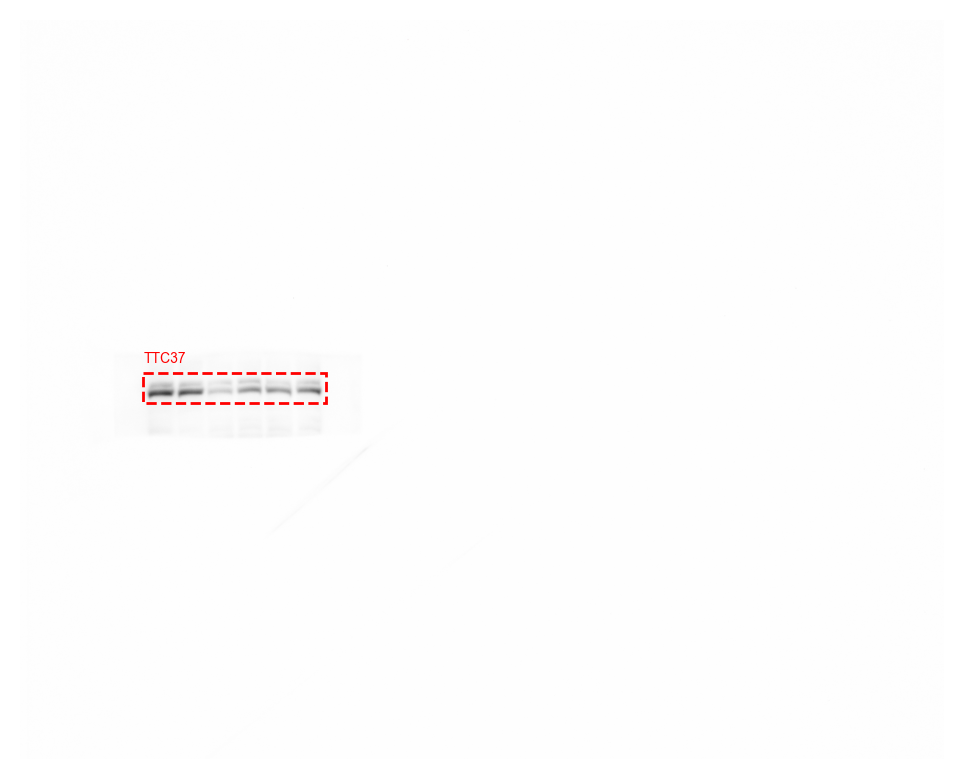

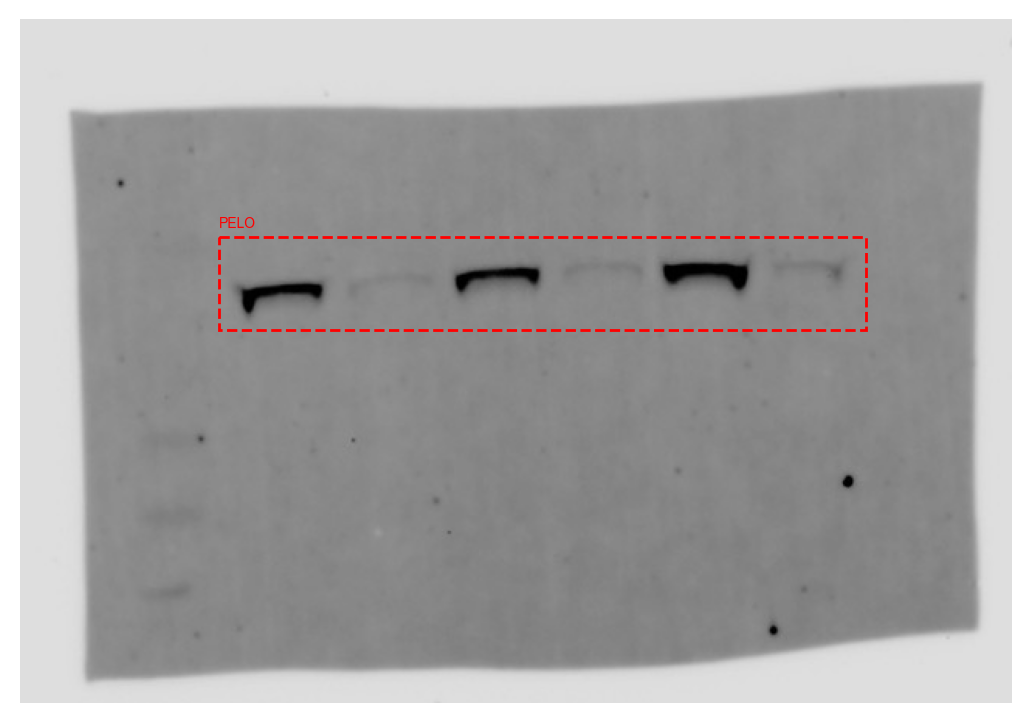

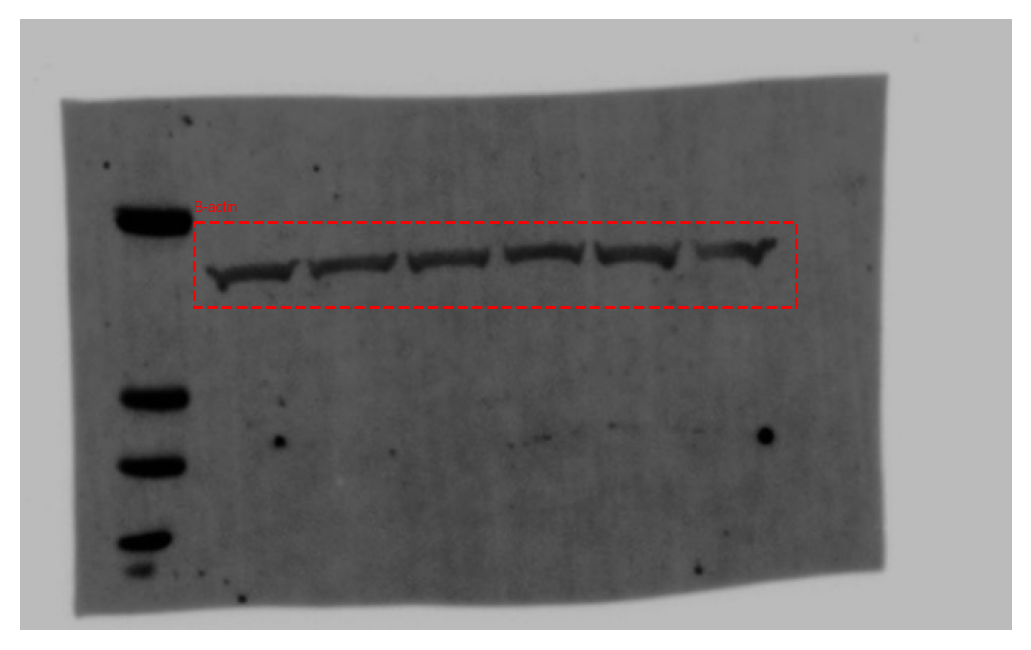

In [18]:
fig3f_TTC37_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 3/Fig3f_TTC37.jpg', {"TTC37":[1290,1400, 450,1120]})
fig3f_PELO_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 3/Fig3f_PELO.jpeg', {"PELO":[140,200, 128,545]})
fig3f_b_actin_cropped = crop_and_box_wb(IMG_FOLDER+'Figure 3/Fig3f_B_actin.jpeg', {"B-actin":[130,185, 112,500]})

## Panel G: TTC37 necessity

In [19]:
fig3g_data = pd.read_excel(SOURCE_DATA_FIG, sheet_name="Fig3g")

fig3g_viab = pd.DataFrame(
    fig3g_data.iloc[2:8, 1:4].values, index=fig3g_data.iloc[2:8, 0].rename("DOX"),
    columns=fig3g_data.iloc[1, 1:3].rename("cDNA")
).stack().to_frame("Relative Viability").reset_index()

In [20]:
#test whether TTC37 cDNA overexpression in DOX-mediated PELO KD leads to increased viability over neg ctrl Luc cDNA
fig3g_stats = ttest_vs_negcons(
    fig3g_viab.loc[fig3g_viab["DOX"] == "DOX+"], "cDNA", neg_cons=["Luc"], to_test=["TTC37"],
    alternative="greater", vals="Relative Viability"
).to_frame("DOX+").T
fig3g_sig = to_scientific(fig3g_stats.loc["DOX+", "p-val"], prefix="$p$=")
fig3g_stats

statistic     p-val  Effect Size    n
DOX+  17.343463  0.000032     0.504733  6.0

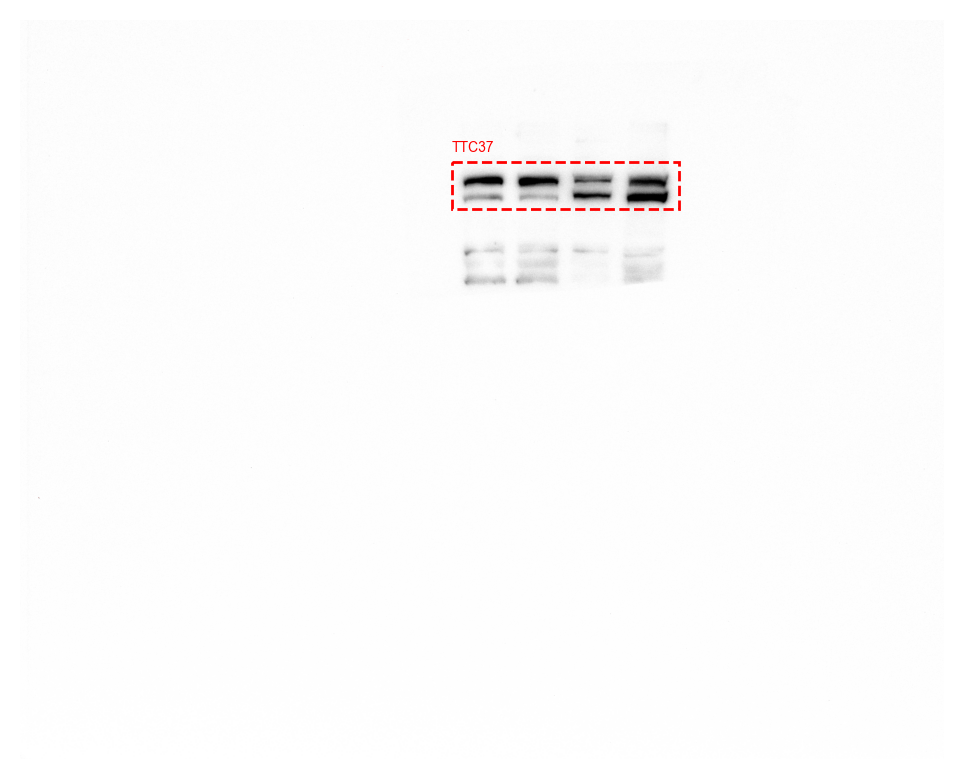

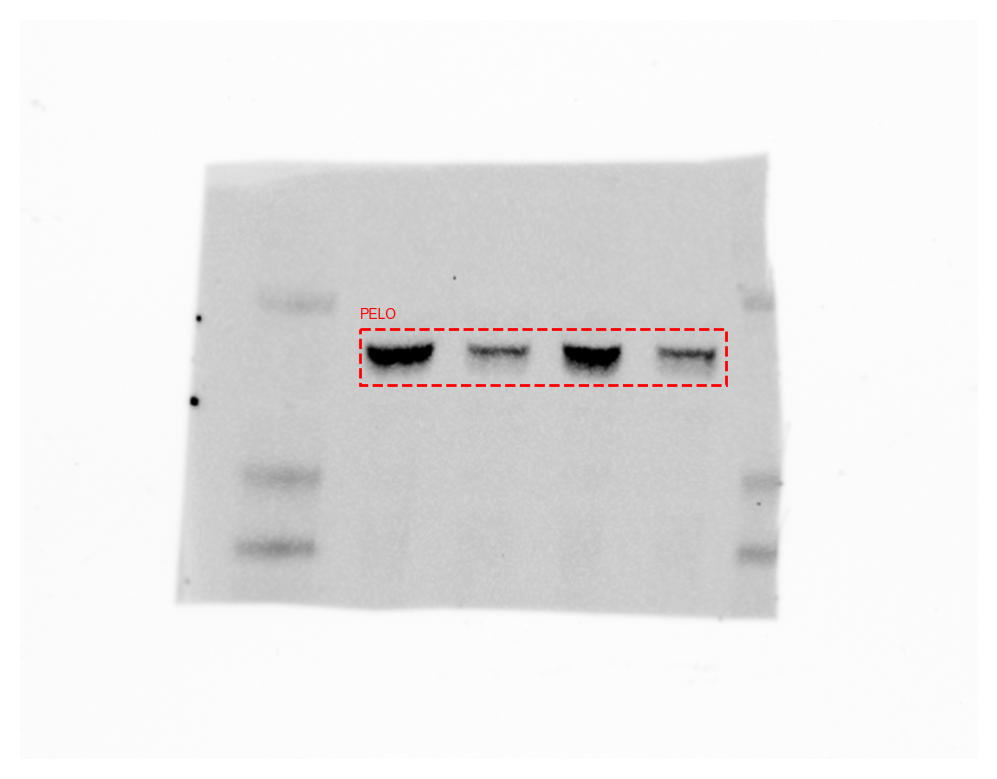

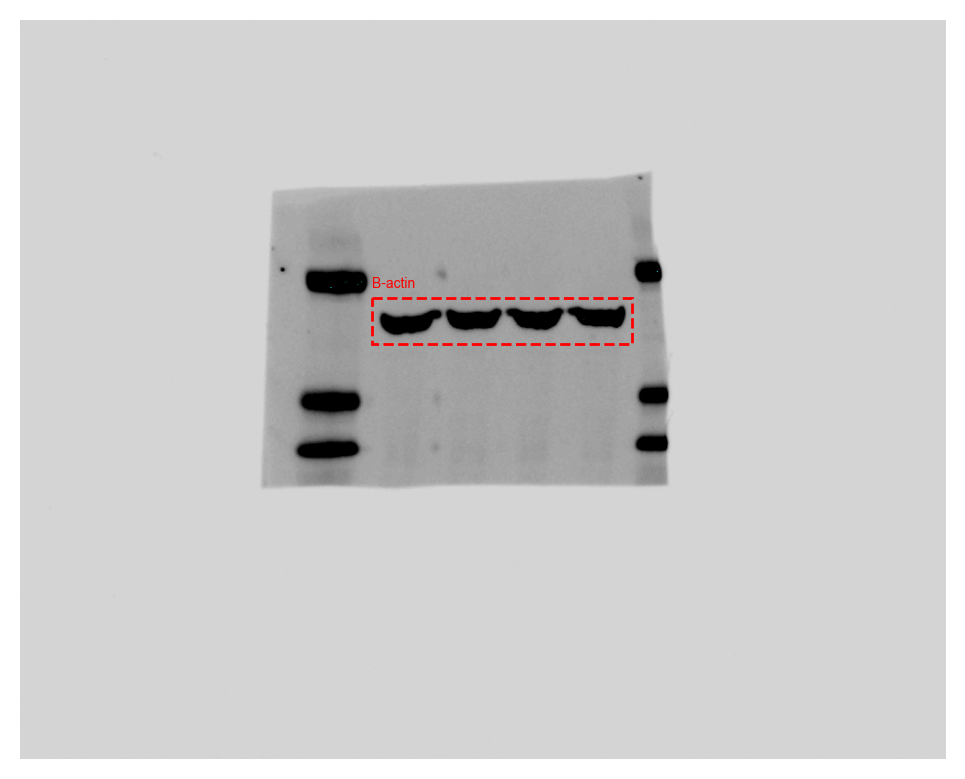

In [21]:
fig3g_TTC37_cropped = crop_and_box_wb(IMG_FOLDER+"Figure 3/Fig3g_TTC37.tif", {"TTC37":[520,690, 1580,2410]})
fig3g_PELO_cropped = crop_and_box_wb(IMG_FOLDER+"Figure 3/Fig3g_PELO.png", {"PELO":[350,413, 385,800]})
fig3g_b_actin_cropped = crop_and_box_wb(IMG_FOLDER+"Figure 3/Fig3g_B_actin.tif", {"B-actin":[300,350, 380,660]})

# Construct Figure 3

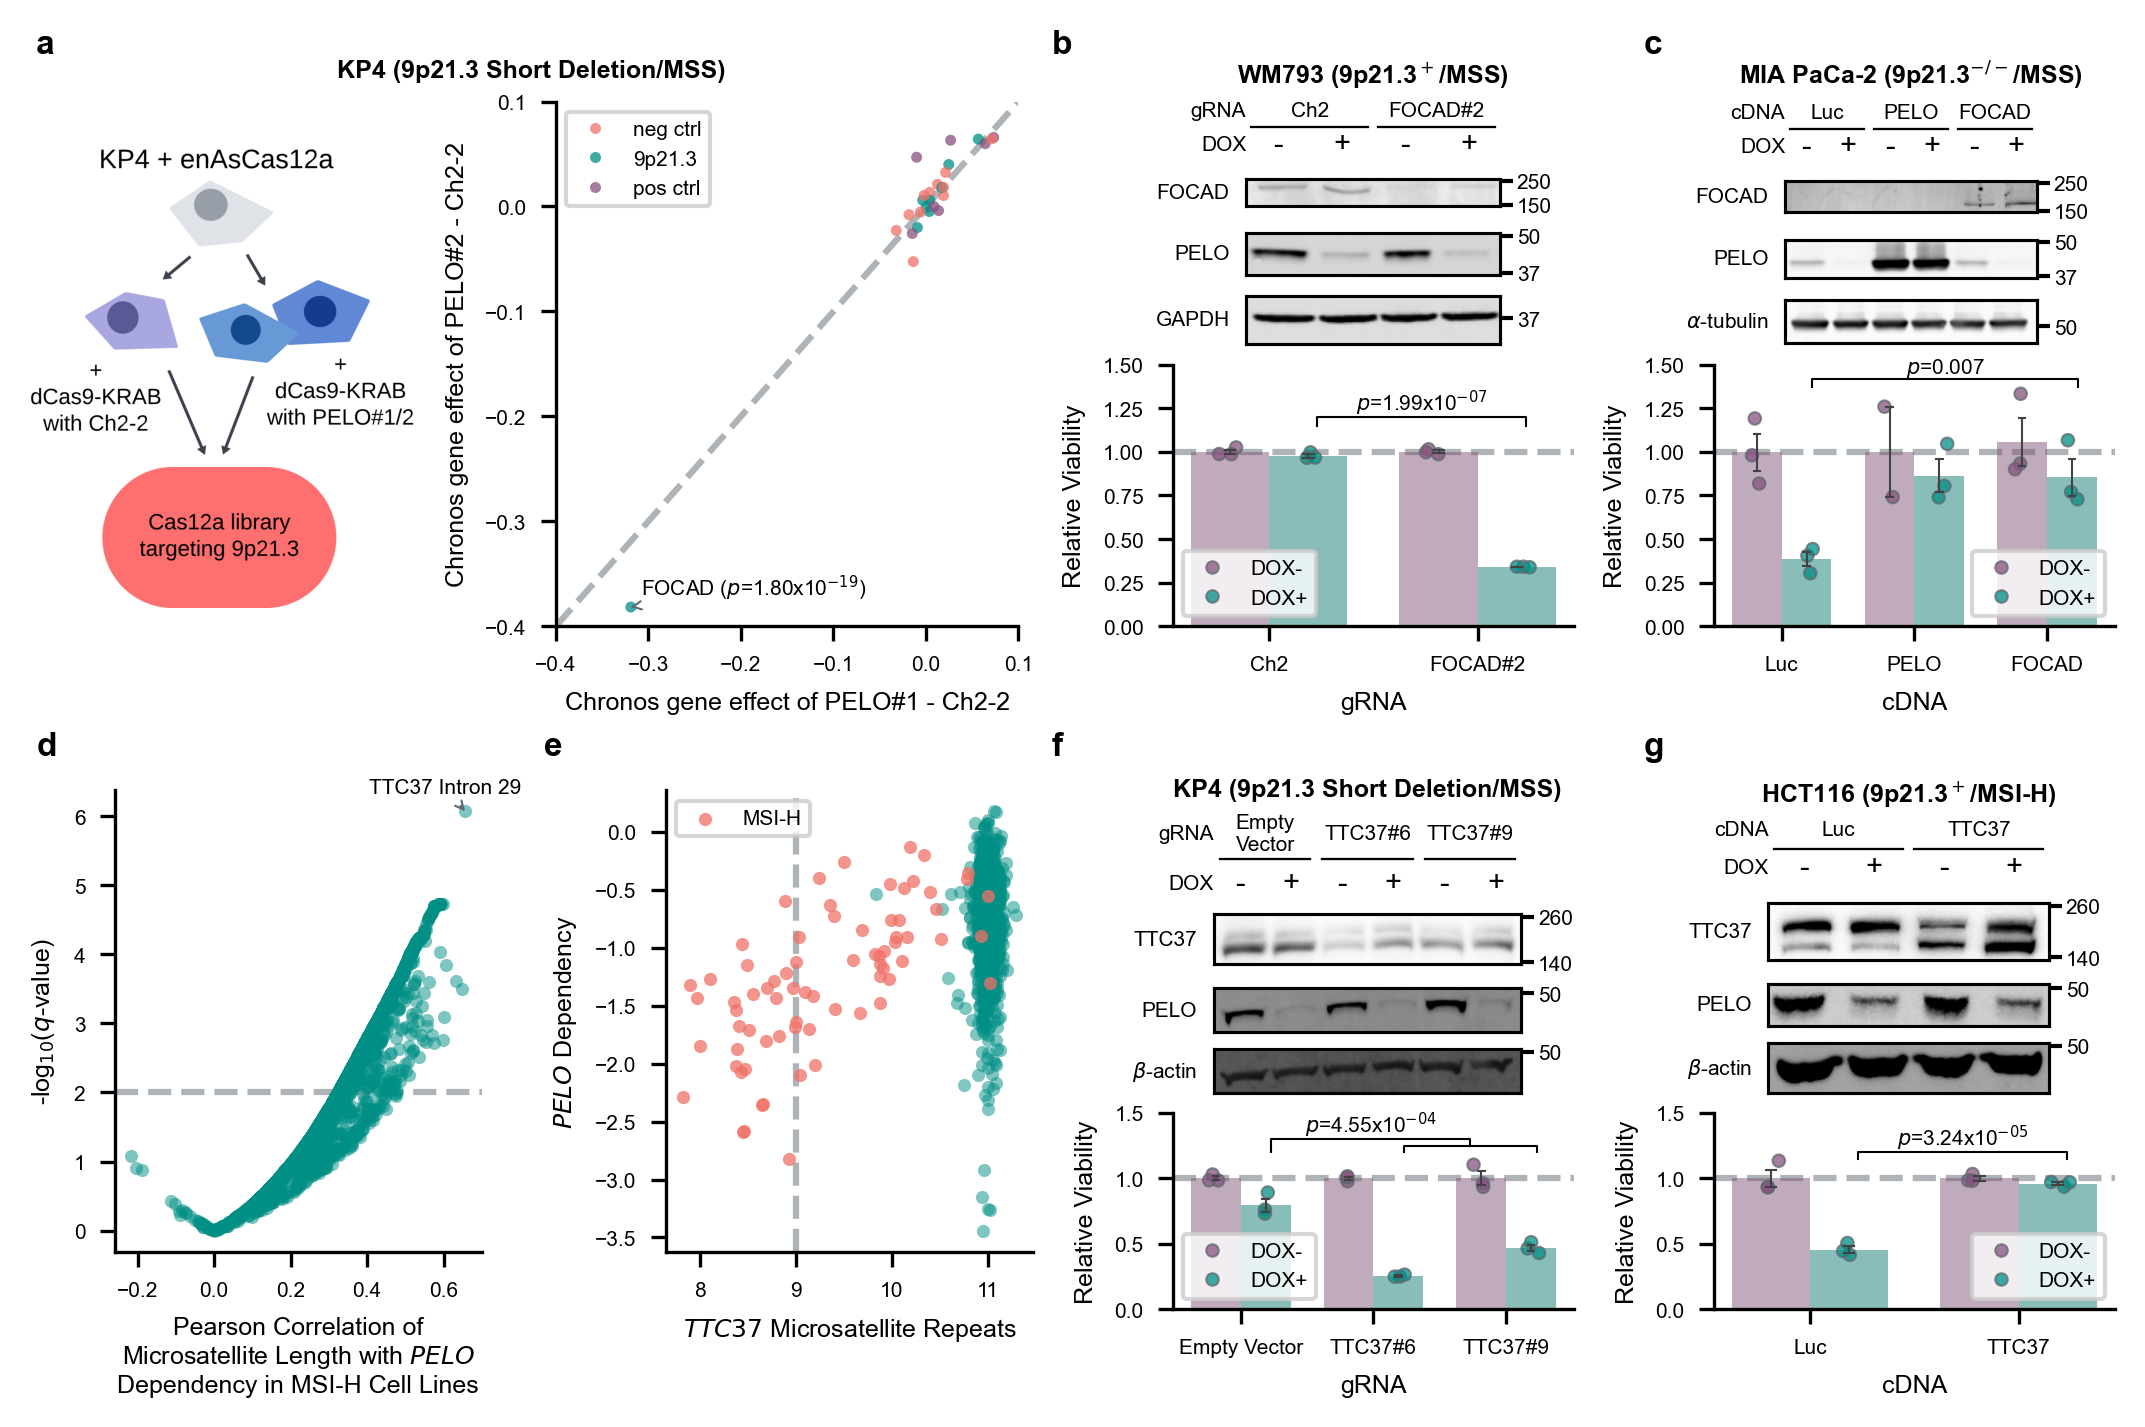

In [22]:
fig3 = plt.figure(layout="constrained", dpi=300, figsize=(DOUBLE_IN, 4.5))

gs = fig3.add_gridspec(nrows=6, ncols=3, height_ratios=[0.05,1,1,0.2,1.25,0.75], width_ratios=[2.5,1,1], hspace=0)

Aa = fig3.add_subplot(gs[0,0])
Aa.annotate(
    "KP4 (9p21.3 Short Deletion/MSS)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
Aa.set_axis_off()
As = gs[1:3, 0].subgridspec(nrows=1, ncols=2, width_ratios=[1,1.2])
A = fig3.add_subplot(As[0, 0])
A.imshow(crispr_mod)
A.set_axis_off()
A1 = fig3.add_subplot(As[0, 1])
quick_scatter(
    fig3a_crispr_mod["PELO1 - Ch2-2"].rename("Chronos gene effect of PELO#1 - Ch2-2"), 
    fig3a_crispr_mod["PELO2 - Ch2-2"].rename("Chronos gene effect of PELO#2 - Ch2-2"), 
    linewidth=0, s=7, alpha=0.75,
    hue=fig3a_crispr_mod["Type"], hue_order=["neg ctrl", "9p21.3", "pos ctrl"], 
    palette=[POS_CON, PELO_GUIDES[1], NEG_CON], ax=A1,
    diagonal=False, hline=None, vline=None
)
A1.set_xlim([-0.4, 0.1])
A1.set_ylim([-0.4, 0.1])
A1.plot([-0.4, 0.1], [-0.4, 0.1], color=ACCENT, linestyle="--", alpha=0.5, zorder=-1)
A1.annotate(
    f"FOCAD ({fig3a_sig})", xy=(fig3a_crispr_mod.loc["FOCAD", "PELO1 - Ch2-2"], fig3a_crispr_mod.loc[ "FOCAD", "PELO2 - Ch2-2"]),
    xytext=(fig3a_crispr_mod.loc["FOCAD", "PELO1 - Ch2-2"]+0.011, fig3a_crispr_mod.loc["FOCAD", "PELO2 - Ch2-2"]+0.005),
    arrowprops=dict(arrowstyle='->', linewidth=0.5, color=ACCENT),
    horizontalalignment='left', verticalalignment='bottom'
)
A1.legend(loc="upper left")

B_ratios = get_wb_height_ratios([
    fig3b_FOCAD_cropped["FOCAD"], fig3b_PELO_cropped["PELO"], fig3b_GAPDH_cropped["GAPDH"]
])
Bs = gs[0:2, 1].subgridspec(nrows=5, ncols=3, width_ratios=[0.25, 1, 0.05], height_ratios=[0.01]+B_ratios, hspace=0)
Bb = fig3.add_subplot(Bs[0, 1])
Bb.annotate(
    r"WM793 (9p21.3$^+$/MSS)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
Bb.set_axis_off()
BL = fig3.add_subplot(Bs[1, 1])
add_wb_labels(
    BL, [("gRNA", ["Ch2", "FOCAD#2"]), ("_", ["_", "_"]), ("DOX", ["-", "+", "-", "+"])]
)
B1 = fig3.add_subplot(Bs[2, 1])
wb_image(B1, "FOCAD", fig3b_FOCAD_cropped["FOCAD"], ladder={"250":0.95, "150":0.05})
B2 = fig3.add_subplot(Bs[3, 1])
wb_image(B2, "PELO", fig3b_PELO_cropped["PELO"], ladder={"50":0.95, "37":0.05})
B3 = fig3.add_subplot(Bs[4, 1])
wb_image(B3, "GAPDH", fig3b_GAPDH_cropped["GAPDH"], ladder={"37":0.55})
B4 = fig3.add_subplot(gs[2, 1])
fancybar(
    data=fig3b_viab,
    x="gRNA", y="Relative Viability", hue="DOX", dodge=True, 
    order=["Ch2", "FOCAD#2"], 
    hue_order=["DOX-", "DOX+"], 
    palette=[NEG_CON, PELO_GUIDES[1]],
    s=3, ax=B4
)
add_bracket(B4, fig3b_sig, [["Ch2", "FOCAD#2"]], 1.2)
B4.set_xlabel("gRNA")
B4.set_ylim(0, 1.5)
axline(B4, "h", 1)
B4.legend(title=None, loc="lower left")

C_ratios = get_wb_height_ratios([
    fig3c_FOCAD_cropped["FOCAD"], fig3c_PELO_cropped["PELO"], fig3c_a_tubulin_cropped["TUB4"]
])
Cs = gs[0:2, 2].subgridspec(nrows=6, ncols=2, width_ratios=[0.2,1], height_ratios=[0.01]+C_ratios+[0.01])
Cc = fig3.add_subplot(Cs[0, 1])
Cc.annotate(
    r"MIA PaCa-2 (9p21.3$^{-/-}$/MSS)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
Cc.set_axis_off()
CL = fig3.add_subplot(Cs[1, 1])
add_wb_labels(
    CL, [("cDNA", ["Luc", "PELO", "FOCAD"]), ("_", ["_", "_", "_"]), ("DOX", ["-", "+", "-", "+", "-", "+"])]
)
C1 = fig3.add_subplot(Cs[2, 1])
wb_image(C1, "FOCAD", fig3c_FOCAD_cropped["FOCAD"], ladder={"250":0.95, "150":0.05})
C2 = fig3.add_subplot(Cs[3, 1])
wb_image(C2, "PELO", fig3c_PELO_cropped["PELO"], ladder={"50":0.95, "37":0.05})
C3 = fig3.add_subplot(Cs[4, 1])
wb_image(C3, r"$\alpha$-tubulin", fig3c_a_tubulin_cropped["TUB4"], ladder={"50":0.40})
C4 = fig3.add_subplot(gs[2, 2])
fancybar(
    data=fig3c_viab,
    x="cDNA", y="Relative Viability", hue="DOX", dodge=True, 
    order=["Luc", "PELO", "FOCAD"],
    hue_order=["DOX-", "DOX+"], palette=[NEG_CON, PELO_GUIDES[1]],
    s=3, ax=C4
)
add_bracket(C4, fig3c_sig, [["Luc", "FOCAD"]], 1.42)
C4.set_ylim(0, 1.5)
axline(C4, "h", 1)
C4.legend(title=None)

DEs = gs[4:6, :1].subgridspec(nrows=1, ncols=2, width_ratios=[1,1])
D = fig3.add_subplot(DEs[0, 0])
quick_scatter(
    x=fig3d_volc["Effect Size"].rename(
        "Pearson Correlation of\nMicrosatellite Length with "r"$PELO$""\nDependency in MSI-H Cell Lines"
    ),
    y=-np.log10(fig3d_volc["q"]).rename("-log$_{10}$($q$-value)"),
    linewidth=0, alpha=0.5, s=10,  ax=D
)
D.annotate(
    "TTC37 Intron 29", xy=(fig3d_volc.loc[ttc37_loc, "Effect Size"], 
                           -np.log10(fig3d_volc.loc[ttc37_loc, "q"])),
    xytext=(fig3d_volc.loc[ttc37_loc, "Effect Size"]-0.25, 
            -np.log10(fig3d_volc.loc[ttc37_loc, "q"])+0.2),
    arrowprops=dict(arrowstyle='->', linewidth=0.5, color=ACCENT),
    horizontalalignment='left', verticalalignment='bottom'
)
axline(D, "h", -np.log10(0.01))

E = fig3.add_subplot(DEs[0, 1])
sns.scatterplot(
    data=fig3e_data[~fig3e_data["MSI-H"]], x="TTC37 Microsatellite Repeats",y="PELO Dependency", 
    linewidth=0, alpha=0.5, s=10, ax=E
)
sns.scatterplot(
    data=fig3e_data[fig3e_data["MSI-H"]], x="TTC37 Microsatellite Repeats",y="PELO Dependency", 
    linewidth=0, alpha=0.75, s=10, 
    label="MSI-H", ax=E
)
axline(E, "v", 9)
E.legend(loc="upper left")
E.set_xlabel("$TTC37$ Microsatellite Repeats")
E.set_ylabel("$PELO$ Dependency")

F_LABEL = (1.2, 5)
F_ratios = get_wb_height_ratios([
    fig3f_TTC37_cropped["TTC37"], fig3f_PELO_cropped["PELO"], fig3f_b_actin_cropped["B-actin"]
], F_LABEL)
Fs = gs[4, 1].subgridspec(nrows=6, ncols=2, width_ratios=[0.2,1], height_ratios=[0.01]+F_ratios+[0.01])
Ff = fig3.add_subplot(Fs[0, 1])
Ff.annotate(
    "KP4 (9p21.3 Short Deletion/MSS)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
Ff.set_axis_off()
FL = fig3.add_subplot(Fs[1, 1])
add_wb_labels(
    FL, [("gRNA", ["Empty\nVector", "TTC37#6", "TTC37#9"]), 
         ("_", ["_", "_", "_"]), ("DOX", ["-", "+", "-", "+", "-", "+"])],
    size=F_LABEL
)
F1 = fig3.add_subplot(Fs[2, 1])
wb_image(F1, "TTC37", fig3f_TTC37_cropped["TTC37"], ladder={"260":0.95, "140":0.05})
F2 = fig3.add_subplot(Fs[3, 1])
wb_image(F2, "PELO", fig3f_PELO_cropped["PELO"], ladder={"50":0.90})
F3 = fig3.add_subplot(Fs[4, 1])
wb_image(F3, r"$\beta$-actin", fig3f_b_actin_cropped["B-actin"], ladder={"50":0.95})
F4 = fig3.add_subplot(gs[5, 1])
F4.set_xlabel(None)
F4.set_ylabel("Relative Viability")
F4.set_ylim(0, 1.5)
fancybar(
    data=fig3f_viab,
    x="gRNA", y="Relative Viability", hue="DOX", dodge=True,
    hue_order=["DOX-", "DOX+"],
    order=["Empty Vector", "TTC37#6", "TTC37#9"],
    palette=[NEG_CON, PELO_GUIDES[1]],
    s=3, ax=F4
)
add_bracket(F4, fig3f_sig, [["Empty Vector"], ["TTC37#6", "TTC37#9"]], 1.3)
F4.set_ylim(0, 1.5)
F4.set_xlabel("gRNA")
axline(F4, "h", 1)
F4.legend(title=None, loc="lower left")

G_ratios = get_wb_height_ratios([
    fig3g_TTC37_cropped["TTC37"], fig3g_PELO_cropped["PELO"], fig3g_b_actin_cropped["B-actin"]
])
Gs = gs[4, 2].subgridspec(nrows=6, ncols=2, width_ratios=[0.2,1], height_ratios=[0.01]+G_ratios+[0.01])
Gg = fig3.add_subplot(Gs[0, 1])
Gg.annotate(
    r"HCT116 (9p21.3$^+$/MSI-H)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
Gg.set_axis_off()
GL = fig3.add_subplot(Gs[1, 1])
add_wb_labels(
    GL, [("cDNA", ["Luc", "TTC37"]), ("_", ["_", "_"]), ("DOX", ["-", "+", "-", "+"])]
)
G1 = fig3.add_subplot(Gs[2, 1])
wb_image(G1, "TTC37", fig3g_TTC37_cropped["TTC37"], ladder={"260":0.95, "140":0.05})
G2 = fig3.add_subplot(Gs[3, 1])
wb_image(G2, "PELO", fig3g_PELO_cropped["PELO"], ladder={"50":0.90})
G3 = fig3.add_subplot(Gs[4, 1])
wb_image(G3, r"$\beta$-actin", fig3g_b_actin_cropped["B-actin"], ladder={"50":0.95})
G4 = fig3.add_subplot(gs[5, 2])
fancybar(
    data=fig3g_viab,
    x="cDNA", y="Relative Viability", hue="DOX", dodge=True,
    order=["Luc","TTC37"], 
    hue_order=["DOX-", "DOX+"], palette=[NEG_CON, PELO_GUIDES[1]],
    s=3, ax=G4
)
add_bracket(G4, fig3g_sig, [["Luc", "TTC37"]], 1.2)
G4.set_ylim(0, 1.5)
axline(G4, "h", 1)
G4.legend(title=None, loc="lower right")


fig3.text(0.01, 1, "a", weight='bold', fontsize=8)
fig3.text(0.49, 1, "b", weight='bold', fontsize=8)
fig3.text(0.77, 1, "c", weight='bold', fontsize=8)
fig3.text(0.01, 0.48, "d", weight='bold', fontsize=8)
fig3.text(0.25, 0.48, "e", weight='bold', fontsize=8)
fig3.text(0.49, 0.48, "f", weight='bold', fontsize=8)
fig3.text(0.77, 0.48, "g", weight='bold', fontsize=8)

fig3.set_constrained_layout_pads(
    w_pad = 0.05, h_pad = 0.02
)

plt.savefig("figures/Fig3.pdf", transparent=True, bbox_inches='tight')
plt.savefig("figures/Fig3.jpg", transparent=True, bbox_inches='tight')

# Prep Extended Figure 3 panels

## Extended Data Panel A: CRISPR modifier library

In [23]:
chr9p21_3 = [
    'CDKN2A','CDKN2B','DMRTA1','ELAVL2','FOCAD','HACD4','IFNA1','IFNA10','IFNA13',
    'IFNA14','IFNA16','IFNA17','IFNA2','IFNA21','IFNA4','IFNA5','IFNA6','IFNA7','IFNA8',
    'IFNB1','IFNE','IFNW1','IZUMO3','KLHL9','MLLT3','MTAP'
]
in_lib = list(set(guide_map['Target']) & set(chr9p21_3))
extfig3a_data = cn.loc[:, cn.columns.str.split(" ").str[0].isin(chr9p21_3)].apply(
    lambda x: pearson(x, gene_effect.loc[df_9p21_cn["Deleted for thresh 0.4"], "PELO (53918)"])
).T.nlargest(25, "R")
extfig3a_data["Symbol"] = extfig3a_data.index.str.split(" ").str[0]
extfig3a_data["In Library"] =  extfig3a_data["Symbol"].isin(in_lib)
extfig3a_data["q"] = pd.Series(
    scipy.stats.false_discovery_control(extfig3a_data["p-val"]), index=extfig3a_data.index
)
extfig3a_data["QLabel"] = extfig3a_data["q"].apply(lambda x: to_scientific(x, prefix="$q$="))

## Extended Data Panel B: KP4 FOCAD sufficiency

In [24]:
extfig3b_data = pd.read_excel(SOURCE_DATA_EXT_FIG, sheet_name="ExtFig3b")

extfig3b_viab = pd.DataFrame(
    extfig3b_data.iloc[1:8, 1:4].values, index=extfig3b_data.iloc[1:8, 0].rename("DOX"),
    columns=extfig3b_data.iloc[0, 1:4].rename("gRNA")
).stack().to_frame("Relative Viability").reset_index()

In [25]:
#test whether FOCAD gRNAs in DOX-mediated PELO KD leads to decreased viability over neg ctrl Ch2 gRNA
extfig3b_stats = ttest_vs_negcons(
    extfig3b_viab.loc[extfig3b_viab["DOX"] == "DOX+"], "gRNA", neg_cons=["Ch2"], to_test=["FOCAD#2", "FOCAD#5"],
    alternative="less", vals="Relative Viability"
).to_frame("DOX+").T
extfig3b_sig = to_scientific(extfig3b_stats.loc["DOX+", "p-val"], prefix="$p$=")
extfig3b_stats

statistic     p-val  Effect Size    n
DOX+ -10.302194  0.000009    -0.510015  9.0

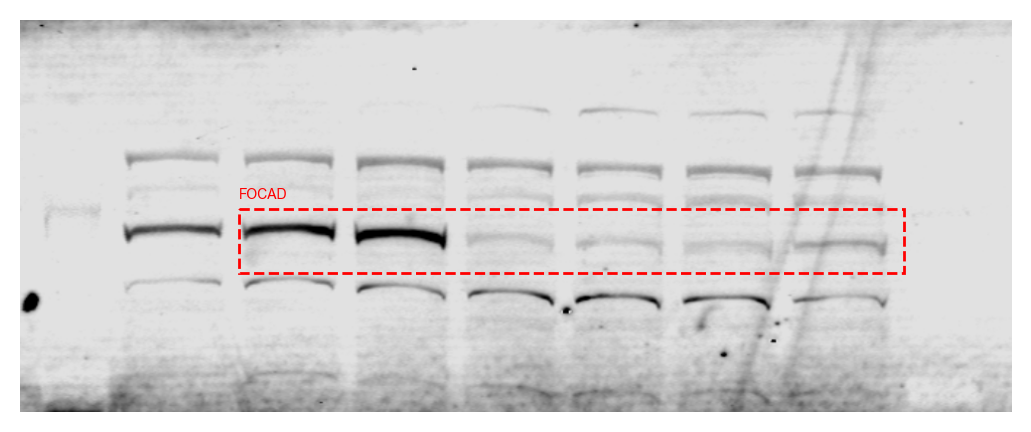

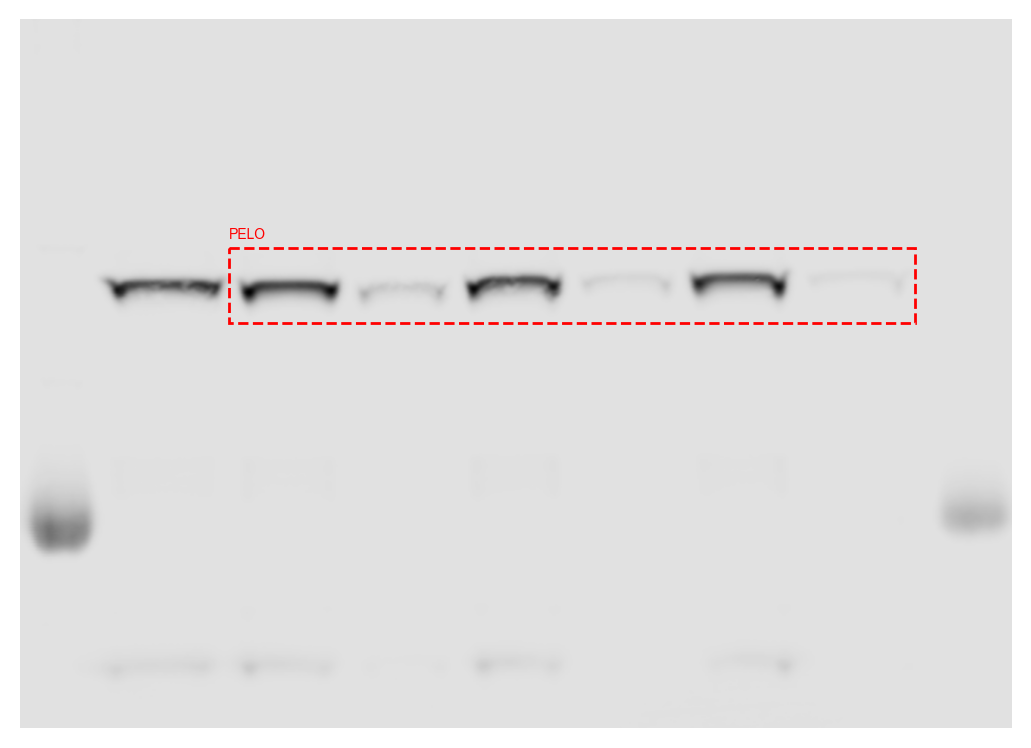

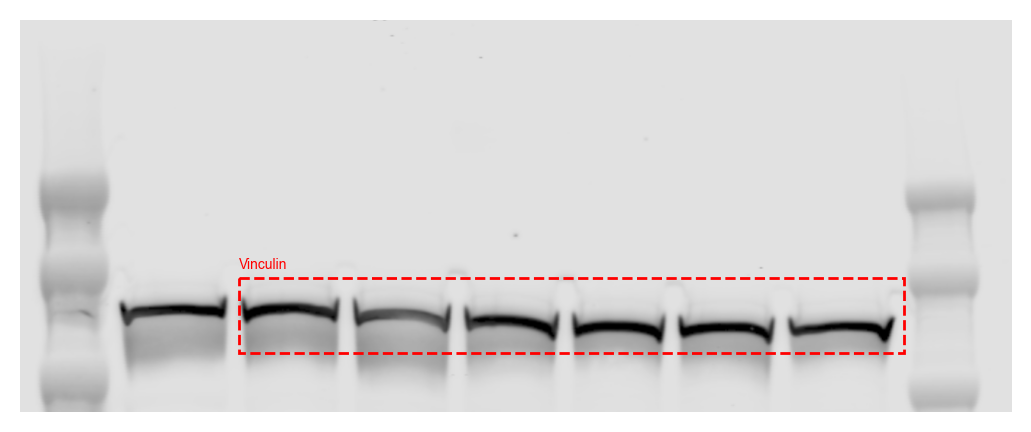

In [26]:
extfig3b_FOCAD_cropped = crop_and_box_wb(IMG_FOLDER+"Extended Figure 3/ExtFig3b_FOCAD.tif", {"FOCAD":[190,255, 220,890]})
extfig3b_PELO_cropped = crop_and_box_wb(IMG_FOLDER+"Extended Figure 3/ExtFig3b_PELO.tif", {"PELO":[230,305, 210,900]})
extfig3b_Vinc_cropped = crop_and_box_wb(IMG_FOLDER+"Extended Figure 3/ExtFig3b_Vinculin.tif", {"Vinculin":[260,335, 220,890]})

## Extended Data Panel C: TCGA Alterations 

In [27]:
extfig3c_data = pd.Series({
    col:(tcga_alterations[col].str.contains(col.split()[-1])).sum() if "HOMDEL" in col 
    else tcga_alterations[col].str.contains("driver").sum()
    for col in ["FOCAD: HOMDEL", "CDKN2A: HOMDEL", "CDKN2B: HOMDEL", "MTAP: HOMDEL", "EGFR: MUT_DRIVER"]
}).to_frame("Altered")
extfig3c_data.index.name = "Alteration"
extfig3c_data["Profiled"] = (tcga_alterations[extfig3c_data.index] != "not profiled").sum()
extfig3c_data["Frequency"] = (extfig3c_data["Altered"] / extfig3c_data["Profiled"]) * 100
extfig3c_data.reset_index(inplace=True)
extfig3c_data["AlterationLabel"] = extfig3c_data["Alteration"].str.replace(" ", "\n")
extfig3c_data

Alteration  Altered  Profiled  Frequency    AlterationLabel
0     FOCAD: HOMDEL      335     10715   3.126458     FOCAD:\nHOMDEL
1    CDKN2A: HOMDEL     1396     10715  13.028465    CDKN2A:\nHOMDEL
2    CDKN2B: HOMDEL     1345     10715  12.552497    CDKN2B:\nHOMDEL
3      MTAP: HOMDEL      978     10715   9.127392      MTAP:\nHOMDEL
4  EGFR: MUT_DRIVER      192     10443   1.838552  EGFR:\nMUT_DRIVER

## Extended Data Panel D: TTC37 Transcript Expression

In [28]:
extfig3d_data = pd.concat({
    "TTC37 Microsatellite Repeats":microsatellite_repeats.loc[ttc37_loc],
    "ENST00000358746 Expression":transcript_expr["TTC37 (ENST00000358746)"],
    "ENST00000508181 Expression":transcript_expr["TTC37 (ENST00000508181)"],
    "MSI-H":pd.Series(microsatellite_repeats.columns.isin(msi_h), index=microsatellite_repeats.columns)
}, axis=1, join="inner")
extfig3d_data.shape[0]

1407

## Extended Data Panel E: TTC37 Protein Expression

In [29]:
extfig3e_data = pd.concat({
    "TTC37 Microsatellite Repeats":microsatellite_repeats.loc[ttc37_loc],
    "TTC37 Protein Level":ccle_proteomics["TTC37"],
    "MSI-H":pd.Series(microsatellite_repeats.columns.isin(msi_h), index=microsatellite_repeats.columns)
}, axis=1, join="inner")
extfig3e_data.shape[0]

372

## Extended Data Panel F: TTC37 indel vs FOCAD loss and PELO dependency

In [30]:
extfig3f_data = pd.concat({
    "FOCAD Relative Copy Number":cn["FOCAD (54914)"],
    "PELO Dependency":gene_effect["PELO (53918)"],
    "TTC37 Indel":microsatellite_repeats.loc[ttc37_loc] <= 9
}, axis=1, join="inner")
extfig3f_data.shape[0], extfig3f_data["TTC37 Indel"].sum()

(1100, 32)

## Extended Data Panel G/H: TTC37 Necessity DLD1 and KM12

In [31]:
extfig3g_data = pd.read_excel(SOURCE_DATA_EXT_FIG, sheet_name="ExtFig3g")

extfig3g_viab = pd.DataFrame(
    extfig3g_data.iloc[1:8, 1:4].values, index=extfig3g_data.iloc[1:8, 0].rename("DOX"),
    columns=extfig3g_data.iloc[0, 1:4].rename("cDNA")
).stack().to_frame("Relative Viability").reset_index()

In [32]:
#test whether TTC37 cDNA overexpression in DOX-mediated PELO KD leads to increased viability over neg ctrl Luc cDNA
extfig3g_stats = ttest_vs_negcons(
    extfig3g_viab.loc[extfig3g_viab["DOX"] == "DOX+"], "cDNA", neg_cons=["Luc cDNA"], to_test=["TTC37 cDNA"],
    alternative="greater", vals="Relative Viability"
).to_frame("DOX+").T
extfig3g_sig = to_scientific(extfig3g_stats.loc["DOX+", "p-val"], prefix="$p$=")
extfig3g_stats

statistic         p-val  Effect Size    n
DOX+  47.857792  5.702267e-07     0.492245  6.0

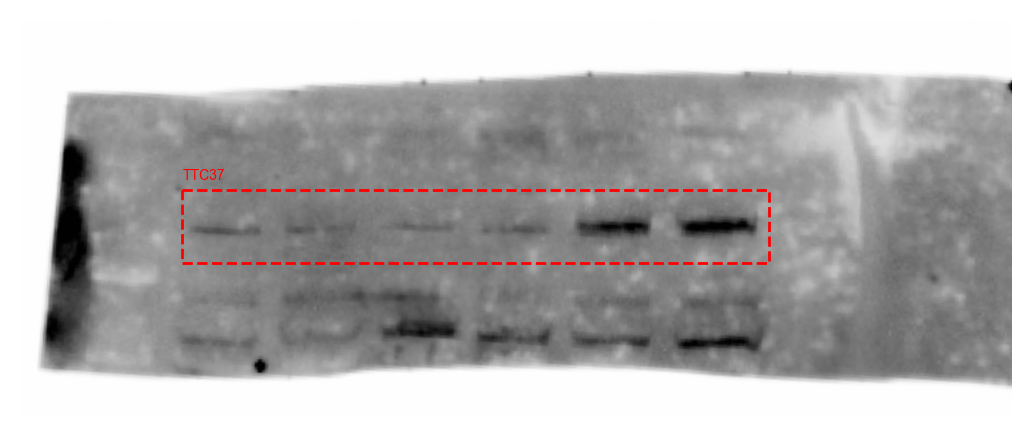

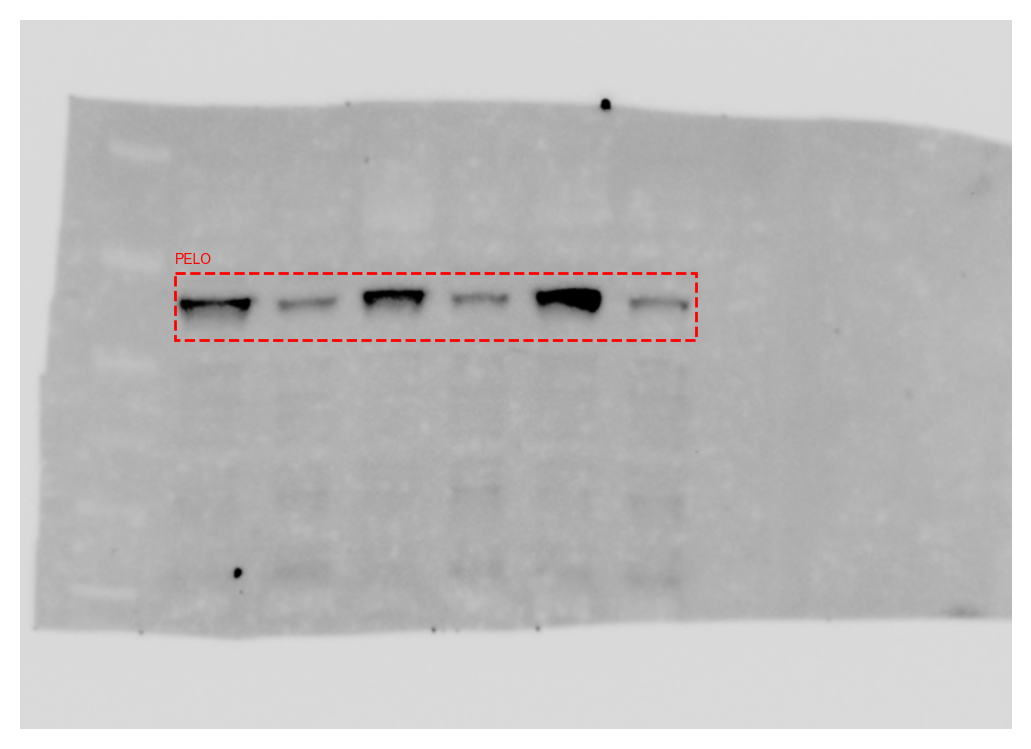

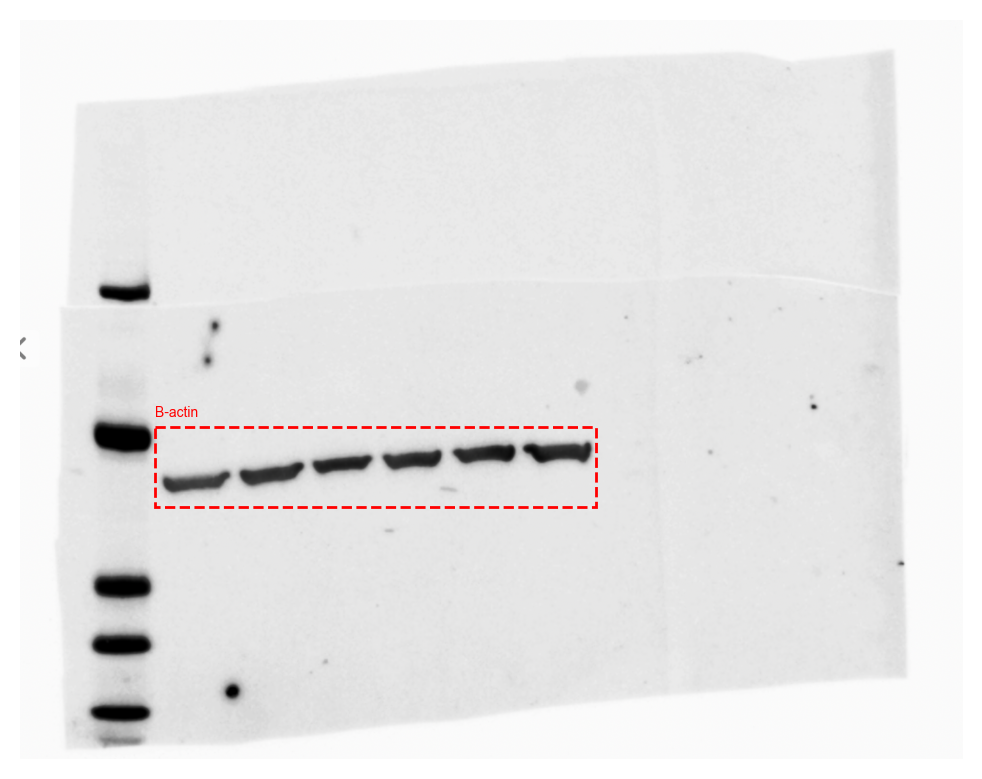

In [33]:
extfig3g_TTC37_cropped = crop_and_box_wb(IMG_FOLDER+'Extended Figure 3/ExtFig3g_TTC37.png', {"TTC37":[220,315, 210,970]})
extfig3g_PELO_cropped = crop_and_box_wb(IMG_FOLDER+'Extended Figure 3/ExtFig3g_PELO.png', {"PELO":[360,455, 220,960]})
extfig3g_b_actin_cropped = crop_and_box_wb(IMG_FOLDER+'Extended Figure 3/ExtFig3g_B_actin.png', {"B-actin":[665,795, 220,940]})

In [34]:
extfig3h_data = pd.read_excel(SOURCE_DATA_EXT_FIG, sheet_name="ExtFig3h")

extfig3h_viab = pd.DataFrame(
    extfig3h_data.iloc[1:8, 1:4].values, index=extfig3h_data.iloc[1:8, 0].rename("DOX"),
    columns=extfig3h_data.iloc[0, 1:4].rename("cDNA")
).stack().to_frame("Relative Viability").reset_index()

In [35]:
#test whether TTC37 cDNA overexpression in DOX-mediated PELO KD leads to increased viability over neg ctrl Luc cDNA
extfig3h_stats = ttest_vs_negcons(
    extfig3h_viab.loc[extfig3h_viab["DOX"] == "DOX+"], "cDNA", neg_cons=["Luc cDNA"], to_test=["TTC37 cDNA"],
    alternative="greater", vals="Relative Viability"
).to_frame("DOX+").T
extfig3h_sig = to_scientific(extfig3h_stats.loc["DOX+", "p-val"], prefix="$p$=")
extfig3h_stats

statistic         p-val  Effect Size    n
DOX+  41.598291  9.980401e-07     0.407848  6.0

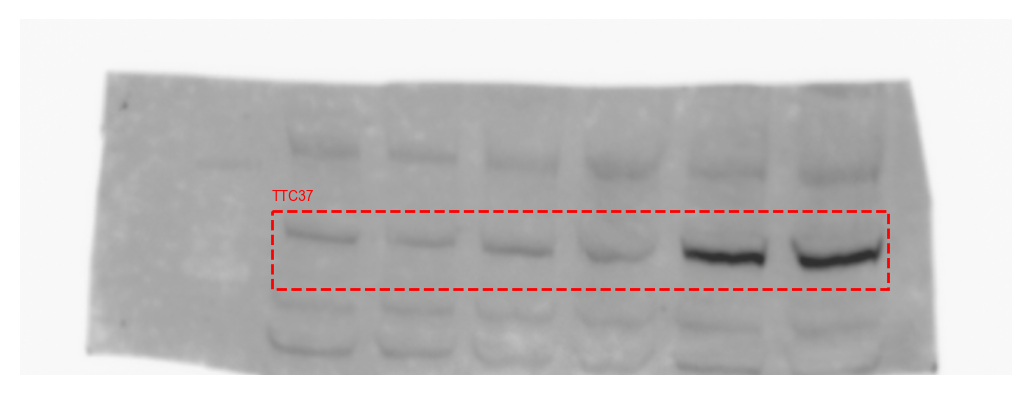

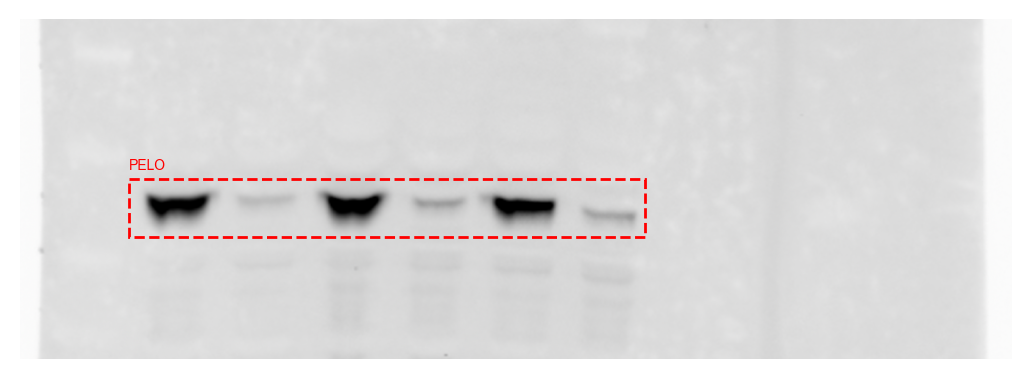

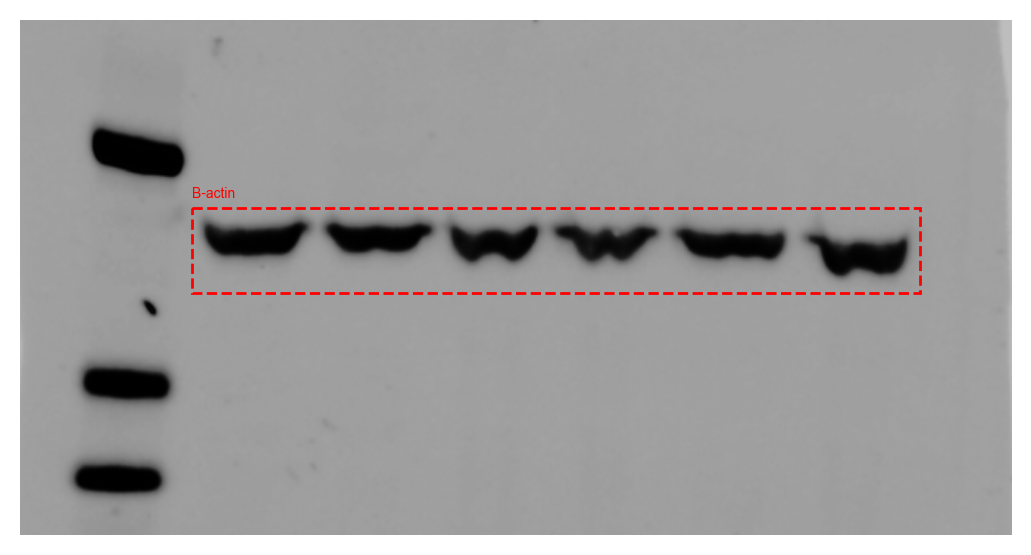

In [36]:
extfig3h_TTC37_cropped = crop_and_box_wb(IMG_FOLDER+'Extended Figure 3/ExtFig3h_TTC37.png', {"TTC37":[220,310, 290,1000]})
extfig3h_PELO_cropped = crop_and_box_wb(IMG_FOLDER+'Extended Figure 3/ExtFig3h_PELO.png', {"PELO":[220,300, 150,860]})
extfig3h_b_actin_cropped = crop_and_box_wb(IMG_FOLDER+'Extended Figure 3/ExtFig3h_B_actin.png', {"B-actin":[186,270, 170,890]})

## Extended Data Panel I: Normals

In [37]:
biomarker_dict = {
    "PELO":(
        "PELO (53918)", 
        ((cn["FOCAD (54914)"] < 0.4) | (microsatellite_repeats.loc[ttc37_loc] <= 9), "FOCAD Loss or\nTTC37 Indel")
    ),
    "KRAS":("KRAS (3845)", (hs_mut["KRAS (3845)"] > 0, "KRAS Hotspot")), 
    "BRAF":("BRAF (673)", (hs_mut["BRAF (673)"] > 0, "BRAF Hotspot")), 
}
in_this_study = pd.Series(
    model_meta["StrippedCellLineName"].isin(
        ['SW620','SW837','SF295','KP4','GB1','SU8686','MIAPACA2','IGROV1','KM12','HCT116']
    ), model_meta.index
).reindex(gene_effect.index).fillna(False)

extfig3i_data = {"In this study":in_this_study}
extfig3i_sigs = {}
for gene, vals in biomarker_dict.items():
    gene_id, labels = vals
    biomarkers = pd.concat([
        pd.Series(labels[1], labels[0].loc[lambda x: x].index)
    ] + [
        pd.Series(
            "Non-cancerous", model_meta.index[
              (model_meta["OncotreePrimaryDisease"] == "Non-Cancerous") &
              ~model_meta["StrippedCellLineName"].str.startswith("RPE1")
        ])
    ])
    biomarkers = biomarkers.groupby(biomarkers.index).apply("+".join).reindex(gene_effect.index).fillna("Other")

    cats = gene_effect[gene_id].groupby(biomarkers).apply(list)
    #test whether gene dependency is more negative in biomarker group then non-cancerous lines
    stats_extfig3i = scipy.stats.ttest_ind(cats[labels[1]], cats["Non-cancerous"], alternative="less")
    print(
        gene, np.mean(cats[labels[1]])-np.mean(cats["Non-cancerous"]), 
        len(cats[labels[1]])+len(cats["Non-cancerous"]), stats_extfig3i, 
    )

    biom_counts = {k:f"{k} (n={v})" for k, v in biomarkers.value_counts().items()}
    extfig3i_data[gene + " Dependency"] = gene_effect[gene_id]
    extfig3i_data[gene + " Biomarkers"] = biomarkers.replace(biom_counts)
    extfig3i_sigs[gene] = (
        to_scientific(stats_extfig3i.pvalue, prefix="$p$="), biom_counts[labels[1]]
    )

extfig3i_data = pd.concat(extfig3i_data, axis=1, join="outer")

PELO -0.9814907381310803 79 TtestResult(statistic=-3.1743956955028496, pvalue=0.0010795099685433878, df=77.0)
KRAS -1.210729564509628 170 TtestResult(statistic=-3.3314741341234573, pvalue=0.0005311437605133107, df=168.0)
BRAF -0.8709897711572884 84 TtestResult(statistic=-2.99072001970873, pvalue=0.0018370672743864174, df=82.0)


# Construct Extended Data Figure

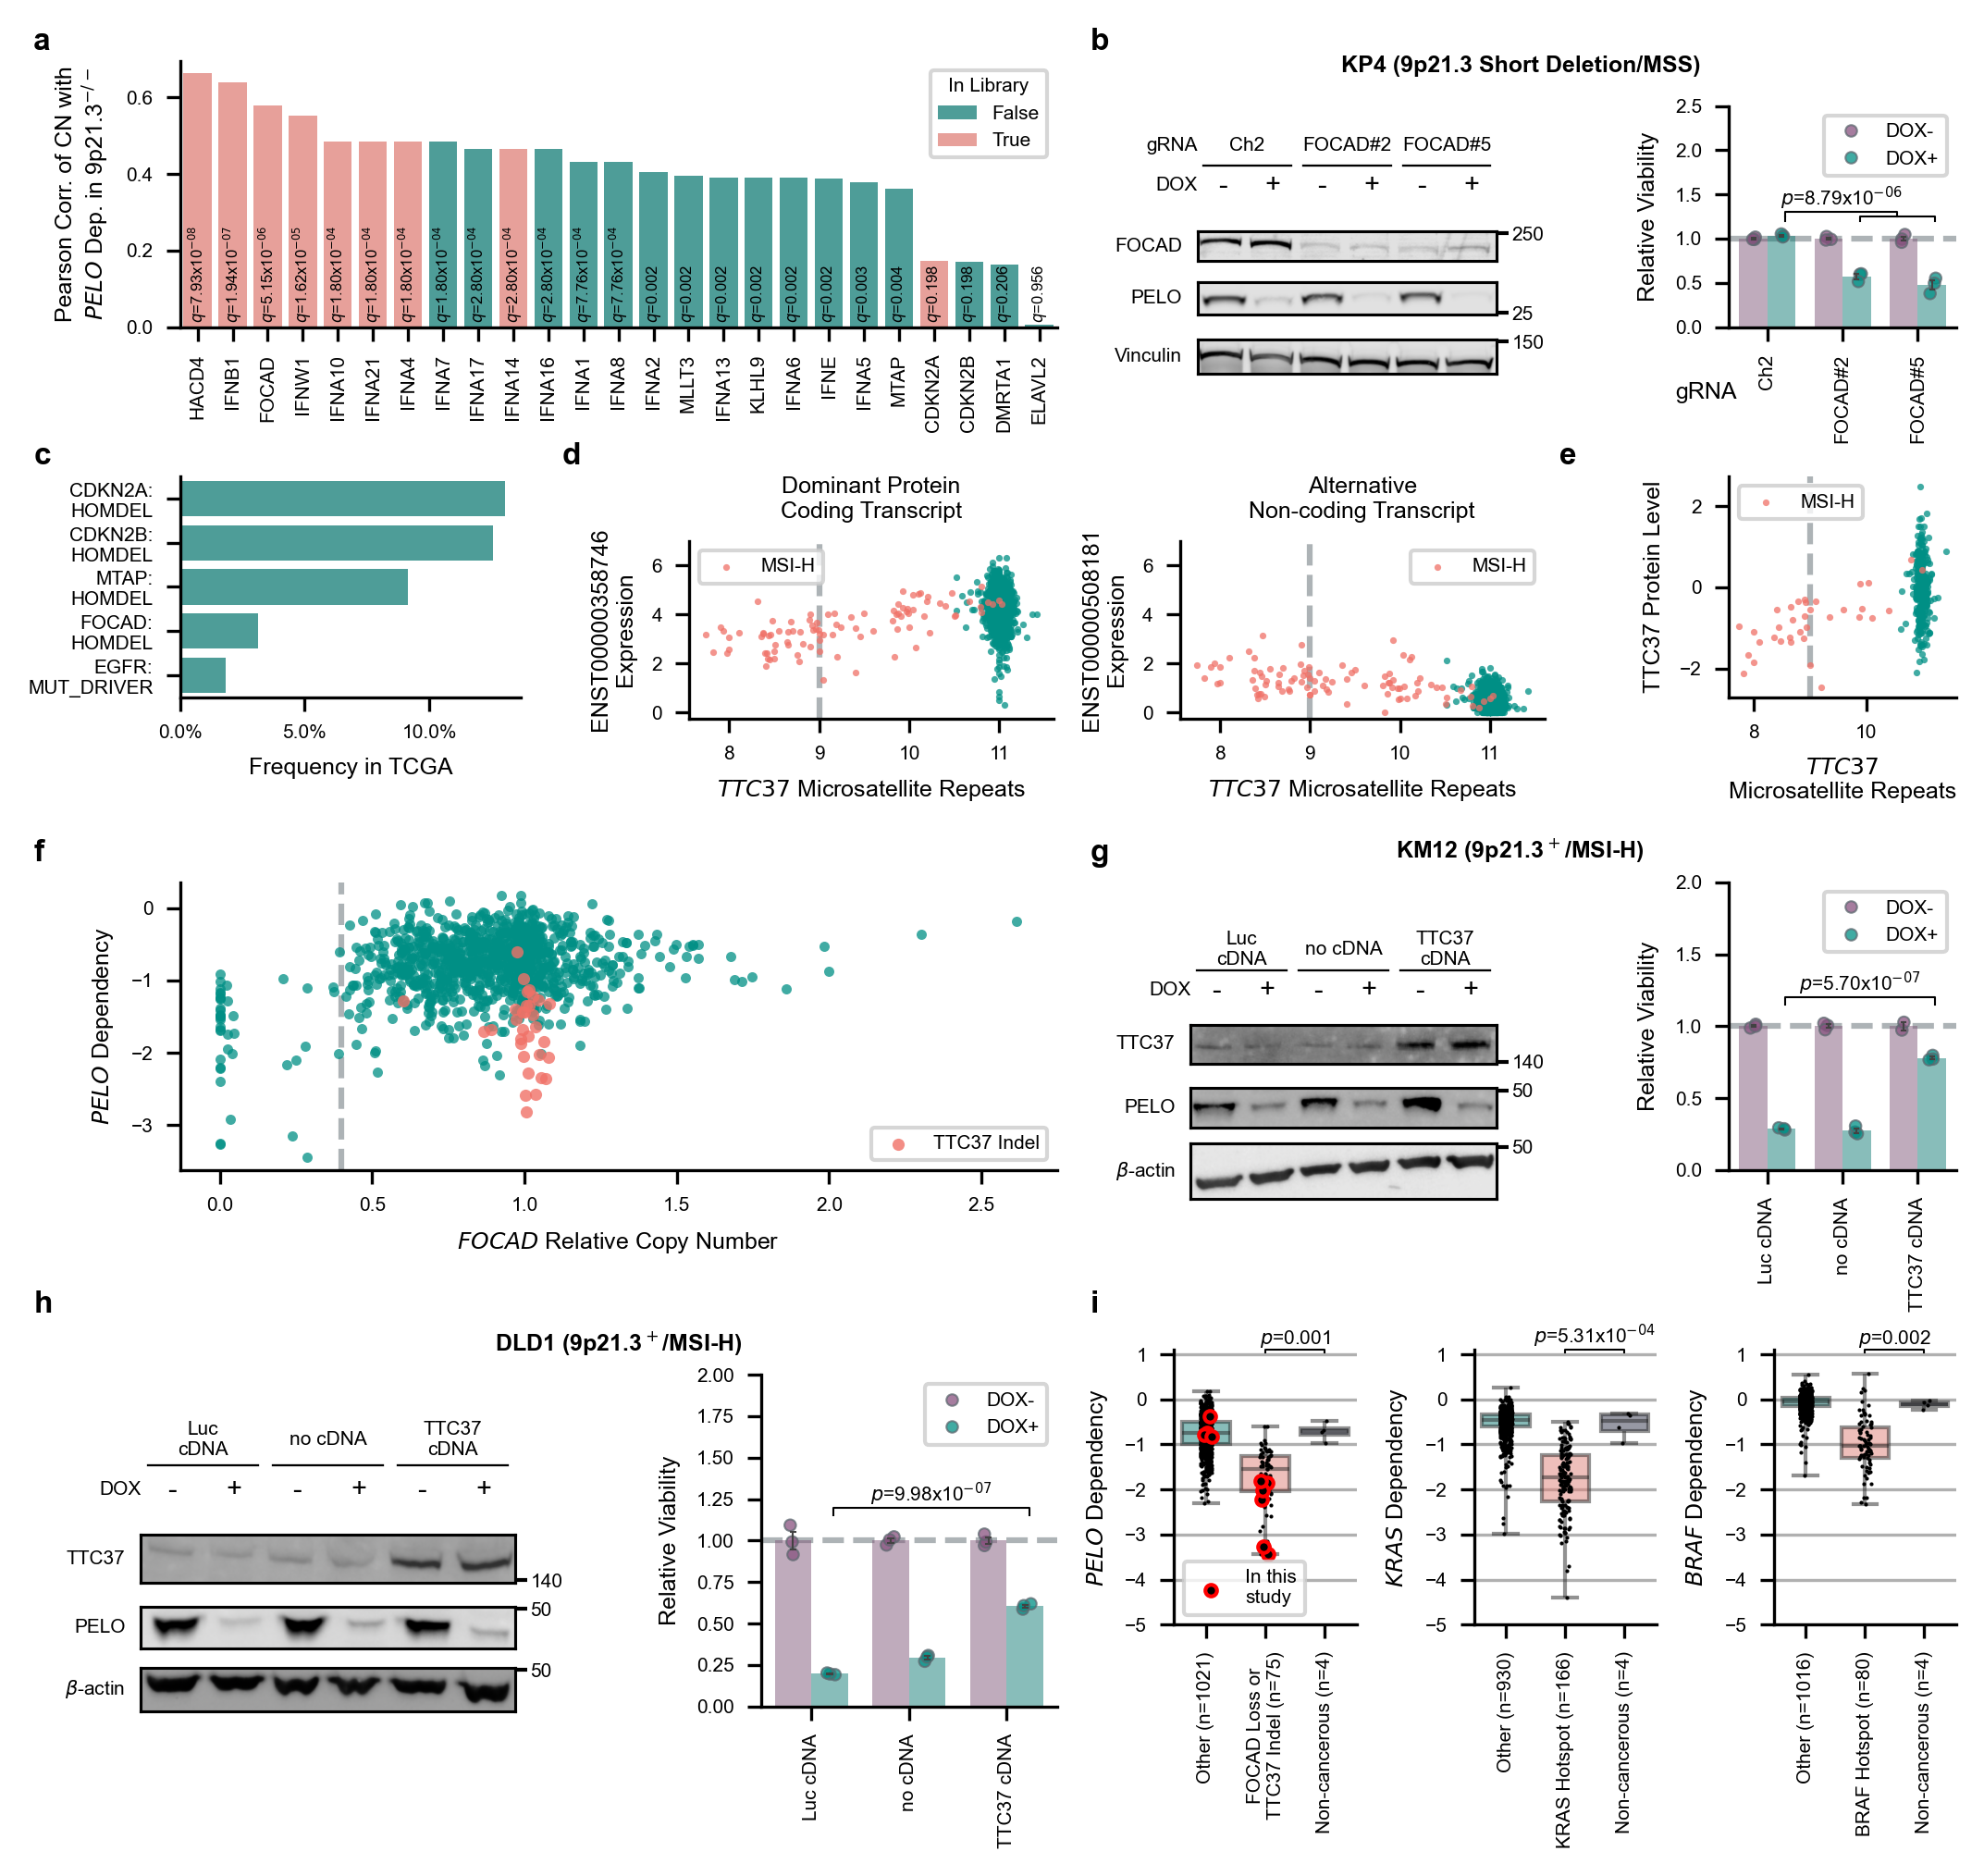

In [38]:
extfig3 = plt.figure(layout="constrained", dpi=300, figsize=(DOUBLE_IN, 6.5))

gs = extfig3.add_gridspec(nrows=9, ncols=4, height_ratios=[0.05, 1, 0.1, 1, 0.1, 0.05, 1.3, 0.1, 1.5], 
                          width_ratios=[1.5,1.3,1.9,1], hspace=0)

A = extfig3.add_subplot(gs[0:2, 0:2])
sns.barplot(data=extfig3a_data, y="R", x="Symbol", hue="In Library", ax=A, alpha=0.75)
for i, (k, row) in enumerate(extfig3a_data.iterrows()):
    A.text(i, 0.01, row["QLabel"], fontsize=4, va="bottom", ha="center", rotation=90)
A.set_ylabel("Pearson Corr. of CN with\n"r"$PELO$ Dep. in 9p21.3$^{-/-}$")
A.set_xlabel(None)
A.set_xticks(A.get_xticks())
A.set_xticklabels(labels=A.get_xticklabels(), rotation=90)


B = extfig3.add_subplot(gs[0,2:])
B.annotate(
    "KP4 (9p21.3 Short Deletion/MSS)", (0.5,0.5), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
B.set_axis_off()
B_ratios = get_wb_height_ratios([
    extfig3b_FOCAD_cropped["FOCAD"], extfig3b_PELO_cropped["PELO"], extfig3b_Vinc_cropped["Vinculin"]
])
Bs = gs[1, 2].subgridspec(nrows=6, ncols=2, width_ratios=[0.1, 1], height_ratios=[1]+B_ratios+[1.5], hspace=0)
BL = extfig3.add_subplot(Bs[1,1])
add_wb_labels(
    BL, [("gRNA",["Ch2", "FOCAD#2", "FOCAD#5"]), ("_", ["_", "_", "_"]), ("DOX",["-", "+", "-", "+", "-","+"])],
)
B1 = extfig3.add_subplot(Bs[2,1])
wb_image(B1, "FOCAD", extfig3b_FOCAD_cropped["FOCAD"], ladder={"250":0.95})
B2 = extfig3.add_subplot(Bs[3,1])
wb_image(B2, "PELO", extfig3b_PELO_cropped["PELO"], ladder={"25":0.05})
B3 = extfig3.add_subplot(Bs[4,1])
wb_image(B3, "Vinculin", extfig3b_Vinc_cropped["Vinculin"], ladder={"150":0.95})

B4 = extfig3.add_subplot(gs[1, 3])
fancybar(
    data=extfig3b_viab,
    x="gRNA", y="Relative Viability", hue="DOX", dodge=True, 
    hue_order=["DOX-", "DOX+"],
    order=["Ch2", "FOCAD#2", "FOCAD#5"],
    palette=[NEG_CON, PELO_GUIDES[1]],
    s=3, ax=B4
)
add_bracket(B4, extfig3b_sig, [["Ch2"], ["FOCAD#2", "FOCAD#5"]], 1.3)
B4.set_xlabel("gRNA")
B4.xaxis.set_label_coords(-0.1, -0.25)
B4.set_ylabel("Relative Viability")
B4.set_ylim(0, 2.5)
B4.set_xticks(ticks=B4.get_xticks(), labels=B4.get_xticklabels(), rotation=90, ha="center")
axline(B4, "h", 1)
B4.legend(title=None, loc="upper right")

C = extfig3.add_subplot(gs[3, 0])
sns.barplot(data=extfig3c_data.sort_values("Frequency", ascending=False), x="Frequency", y="AlterationLabel", ax=C, alpha=0.75)
C.xaxis.set_major_formatter(mtick.PercentFormatter())
C.set_xlabel("Frequency in TCGA")
C.set_ylabel(None)


Ds = gs[3, 1:3].subgridspec(nrows=1, ncols=2, hspace=0)
D1 = extfig3.add_subplot(Ds[0])
sns.scatterplot(
    data=extfig3d_data[~extfig3d_data["MSI-H"]], x="TTC37 Microsatellite Repeats", y="ENST00000358746 Expression",
    alpha=0.75, s=3, linewidth=0, ax=D1
)
sns.scatterplot(
    data=extfig3d_data[extfig3d_data["MSI-H"]], x="TTC37 Microsatellite Repeats", y="ENST00000358746 Expression",
    alpha=0.75, s=3, linewidth=0, ax=D1, label="MSI-H"
)
D1.set_xlabel("$TTC37$"" Microsatellite Repeats")
D1.set_ylabel("ENST00000358746\nExpression")
D1.set_title("Dominant Protein\nCoding Transcript")
axline(D1, "v", 9)
D1.set_ylim(-0.25, 7)
D1.legend(loc="upper left", title=None)
D2 = extfig3.add_subplot(Ds[1])
sns.scatterplot(
    data=extfig3d_data[~extfig3d_data["MSI-H"]], x="TTC37 Microsatellite Repeats", y="ENST00000508181 Expression", 
    alpha=0.75, s=3, linewidth=0, ax=D2
)
sns.scatterplot(
    data=extfig3d_data[extfig3d_data["MSI-H"]], x="TTC37 Microsatellite Repeats", y="ENST00000508181 Expression", 
    alpha=0.75, s=3, linewidth=0, ax=D2, label="MSI-H"
)
D2.set_xlabel("$TTC37$"" Microsatellite Repeats")
D2.set_ylabel("ENST00000508181\nExpression")
D2.set_title("Alternative\nNon-coding Transcript")
axline(D2, "v", 9)
D2.set_ylim(-0.25, 7)

E = extfig3.add_subplot(gs[3, 3])
sns.scatterplot(
    data=extfig3e_data[~extfig3e_data["MSI-H"]], x="TTC37 Microsatellite Repeats", y="TTC37 Protein Level", 
    alpha=0.75, s=3, linewidth=0, ax=E
)
sns.scatterplot(
    data=extfig3e_data[extfig3e_data["MSI-H"]], x="TTC37 Microsatellite Repeats", y="TTC37 Protein Level", 
    alpha=0.75, s=3, linewidth=0, ax=E, label="MSI-H"
)
E.set_xlabel("$TTC37$""\nMicrosatellite Repeats")
axline(E, "v", 9)
E.legend(loc="upper left", title=None)

F = extfig3.add_subplot(gs[6, :2])
sns.scatterplot(
    data=extfig3f_data[~extfig3f_data["TTC37 Indel"]], x="FOCAD Relative Copy Number", y="PELO Dependency",
    alpha=0.75, s=7, linewidth=0, color=PELO_GUIDES[1], ax=F
)
sns.scatterplot(
    data=extfig3f_data[extfig3f_data["TTC37 Indel"]], x="FOCAD Relative Copy Number", y="PELO Dependency",
    alpha=0.8, s=10, linewidth=0, color=POS_CON, label="TTC37 Indel", ax=F
)
F.set_xlabel("$FOCAD$ Relative Copy Number")
F.set_ylabel("$PELO$ Dependency")
F.legend(loc="lower right")
axline(F, "v", 0.4)

G = extfig3.add_subplot(gs[5,2:])
G.annotate(
    r"KM12 (9p21.3$^+$/MSI-H)", (0.5,0.1), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
G.set_axis_off()
G_ratios = get_wb_height_ratios([
    extfig3g_TTC37_cropped["TTC37"], extfig3g_PELO_cropped["PELO"], extfig3g_b_actin_cropped["B-actin"]
])
Gs = gs[6, 2].subgridspec(nrows=6, ncols=2, width_ratios=[0.1,1], height_ratios=[1]+G_ratios+[2], hspace=0)
GL = extfig3.add_subplot(Gs[1,1])
add_wb_labels(
    GL, [
        ("", ["Luc\ncDNA", "no cDNA", "TTC37\ncDNA"]), 
        ("_", ["_", "_", "_"]), ("DOX",["-", "+", "-", "+", "-", "+"])
    ]
)
G1 = extfig3.add_subplot(Gs[2,1])
wb_image(G1, "TTC37", extfig3g_TTC37_cropped["TTC37"], ladder={"140":0.05})
G2 = extfig3.add_subplot(Gs[3,1])
wb_image(G2, "PELO", extfig3g_PELO_cropped["PELO"], ladder={"50":0.95})
G3 = extfig3.add_subplot(Gs[4,1])
wb_image(G3, r"$\beta$-actin", extfig3g_b_actin_cropped["B-actin"], ladder={"50":0.95})

G4 = extfig3.add_subplot(gs[6, 3])
fancybar(
    data=extfig3g_viab,
    x="cDNA", y="Relative Viability", hue="DOX", dodge=True,
    hue_order=["DOX-", "DOX+"],
    order=["Luc cDNA", "no cDNA", "TTC37 cDNA"],
    palette=[NEG_CON, PELO_GUIDES[1]],
    s=3, ax=G4
)
add_bracket(G4, extfig3g_sig, [["Luc cDNA", "TTC37 cDNA"]], 1.2)
G4.set_xlabel(None)
G4.set_ylabel("Relative Viability")
G4.set_xticks(ticks=G4.get_xticks(), labels=G4.get_xticklabels(), rotation=90, ha="center")
G4.set_ylim(0, 2)
axline(G4, "h", 1)
G4.legend(title=None, loc="upper right")

H = extfig3.add_subplot(gs[7,:2])
H.annotate(
    r"DLD1 (9p21.3$^+$/MSI-H)", (0.5,0.1), 
    horizontalalignment='center', verticalalignment='center', 
    weight="bold", fontsize=6
)
H.set_axis_off()
H_ratios = get_wb_height_ratios([
    extfig3h_TTC37_cropped["TTC37"], extfig3h_PELO_cropped["PELO"], extfig3h_b_actin_cropped["B-actin"]
])
Hs = gs[8, 0].subgridspec(nrows=6, ncols=2, width_ratios=[.1,1], height_ratios=[1]+H_ratios+[2.5], hspace=0)
HL = extfig3.add_subplot(Hs[1,1])
add_wb_labels(
    HL, [
        ("", ["Luc\ncDNA", "no cDNA", "TTC37\ncDNA"]),
        ("_", ["_", "_", "_"]), ("DOX",["-", "+", "-", "+", "-", "+", ])
    ],
)
H1 = extfig3.add_subplot(Hs[2,1])
wb_image(H1, "TTC37", extfig3h_TTC37_cropped["TTC37"], ladder={"140":0.05})
H2 = extfig3.add_subplot(Hs[3,1])
wb_image(H2, "PELO", extfig3h_PELO_cropped["PELO"], ladder={"50":0.95})
H3 = extfig3.add_subplot(Hs[4,1])
wb_image(H3, r"$\beta$-actin", extfig3h_b_actin_cropped["B-actin"], ladder={"50":0.95})

H4 = extfig3.add_subplot(gs[8, 1])
fancybar(
    data=extfig3h_viab,
    x="cDNA", y="Relative Viability", hue="DOX", dodge=True,
    hue_order=["DOX-", "DOX+"],
    order=["Luc cDNA", "no cDNA", "TTC37 cDNA"],
    palette=[NEG_CON, PELO_GUIDES[1]],
    s=3, ax=H4
)
add_bracket(H4, extfig3h_sig, [["Luc cDNA", "TTC37 cDNA"]], 1.2)
H4.set_xlabel(None)
H4.set_ylabel("Relative Viability")
H4.set_xticks(ticks=H4.get_xticks(), labels=H4.get_xticklabels(), rotation=90, ha="center")
H4.set_ylim(0, 2)
axline(H4, "h", 1)
H4.legend(title=None, loc="upper right")


Is = gs[7:, 2:].subgridspec(nrows=1, ncols=len(biomarker_dict.keys()))
for i, gene in enumerate(biomarker_dict.keys()):
    In = extfig3.add_subplot(Is[i])
    sns.boxplot(
        data=extfig3i_data, y=gene+" Dependency", x=gene+" Biomarkers", ax=In,
        hue=gene+" Biomarkers", boxprops=dict(alpha=0.5), whiskerprops=dict(alpha=0.5),  whis=(0, 100),
        medianprops=dict(alpha=0.5), capprops=dict(alpha=0.5), showfliers=False, palette=COLORS[:2]+COLORS[3:4]
    )
    sns.stripplot(
        data=extfig3i_data, y=gene+" Dependency", x=gene+" Biomarkers", color="k",  ax=In, s=1
    )
    if gene == "PELO":
        sns.stripplot(
            data=extfig3i_data[in_this_study], y=gene+" Dependency", x=gene+" Biomarkers", color="k",  
            ax=In, s=3, linewidth=1, edgecolor="r", label="In this\nstudy"
        )
        lgd, keys = In.get_legend_handles_labels()
        d = dict(zip(keys, lgd))
        In.legend(d.values(), d.keys(), loc="lower left")
    add_bracket(In, extfig3i_sigs[gene][0], [[extfig3i_sigs[gene][1], "Non-cancerous (n=4)"]], 1.1, dx=0)
    In.set_ylabel(f"${gene}$"+" Dependency")
    In.set_xlabel(None)
    In.set_xticks(ticks=In.get_xticks(), labels=In.get_xticklabels(), rotation=90, ha="center")
    In.grid(axis="y")
    In.set_ylim(-5, 1.1)

extfig3.text(0.01, 1, "a", weight='bold', fontsize=8)
extfig3.text(0.55, 1, "b", weight='bold', fontsize=8)
extfig3.text(0.01, 0.77, "c", weight='bold', fontsize=8)
extfig3.text(0.28, 0.77, "d", weight='bold', fontsize=8)
extfig3.text(0.79, 0.77, "e", weight='bold', fontsize=8)
extfig3.text(0.01, 0.55, "f", weight='bold', fontsize=8)
extfig3.text(0.55, 0.55, "g", weight='bold', fontsize=8)
extfig3.text(0.01, 0.30, "h", weight='bold', fontsize=8)
extfig3.text(0.55, 0.30, "i", weight='bold', fontsize=8)

extfig3.set_constrained_layout_pads(
    w_pad = 0.05, h_pad = 0.02
)

plt.savefig("figures/ExtFig3.pdf", transparent=True, bbox_inches='tight',)
plt.savefig("figures/ExtFig3.jpg", transparent=True, bbox_inches='tight',)

# Save Outputs

In [39]:
fig3a_crispr_mod.rename_axis("Gene").to_csv("outputs/Fig3a.csv")
fig3d_volc.to_csv("outputs/Fig3d.csv")
fig3e_data.rename_axis("ModelID").to_csv("outputs/Fig3e.csv")

In [40]:
extfig3a_data.rename_axis("Gene").drop(columns="QLabel").to_csv("outputs/ExtFig3a.csv")
extfig3c_data.drop(columns="AlterationLabel").to_csv("outputs/ExtFig3c.csv", index=None)
extfig3d_data.rename_axis("ModelID").to_csv("outputs/ExtFig3d.csv")
extfig3e_data.rename_axis("ModelID").to_csv("outputs/ExtFig3e.csv")
extfig3f_data.rename_axis("ModelID").to_csv("outputs/ExtFig3f.csv")
extfig3i_data.rename_axis("ModelID").replace("FOCAD Loss or\nTTC37 Indel (n=75)", "FOCAD Loss or TTC37 Indel (n=75)")\
                .to_csv("outputs/ExtFig3i.csv")